# Workflow para calcular el número de Rossby baroclínico en la corriente de Canarias

Un workflow sirve para procesar grandes volúmenes de datos que puedan ser tratados por partes. En nuestro caso, vamos a procesar los datos de las velocidades horizontales (u,v) en función de la latitud, longitud y tiempo (lon,lat,t) para 2 capas (0 y ~400 m), ya que para cada par nos interesa calcular el número de Rossby baroclínico dado por:

$Ro_b = \left|\frac{\zeta_b}{f}\right|$

con $\zeta_b = \zeta_{z=0 m} - \zeta_{z=-400 m}$

La forma en que haremos la **paralelización** será por el eje temporal. De modo que cada hilo (o _thread_) calculará $Ro_b$ para un tiempo distinto, tanto para todas las longitudes de onda, como para sus componentes de alto y bajo número de onda, divididos mediante la escala de transición en donde las ondas internas dominan sobre los movimientos en balance.

Para la caja 771 de LLC4320, esta escala se tomará a unos 75 km.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import geopandas as gpd
#import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

from xmitgcm import llcreader

In [3]:
import dask,xmitgcm,numpy
print(dask.__version__)
print(xmitgcm.__version__)
print(numpy.__version__)

1.1.4
0.4.1+9.gde396c2
1.17.3


In [4]:
# Resolución: Puntos por grado
map_res = 48

In [5]:
if map_res==24:
    model = llcreader.ECCOPortalLLC2160Model()
elif map_res==48:
    model = llcreader.ECCOPortalLLC4320Model()
else:
    raise Exception("Invalid resolution")
model.varnames

['Eta',
 'KPPhbl',
 'oceFWflx',
 'oceQnet',
 'oceQsw',
 'oceSflux',
 'oceTAUX',
 'oceTAUY',
 'PhiBot',
 'Salt',
 'SIarea',
 'SIheff',
 'SIhsalt',
 'SIhsnow',
 'SIuice',
 'SIvice',
 'Theta',
 'U',
 'V',
 'W']

In [6]:
## Variables a utilizar en el workflow (_wf)
vars_wf = ["U","V"] # Variables del modelo

In [7]:
# Parámetros para la extracción de los datos
map_mode = 'faces' # 'faces' or 'latlon'
cols2drop_uv=['time','niter','face','k']
area_face=2 # Los datos de Canarias están en la cara 2: https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Plotting_Tiles.html
#area_face=10 # Los datos de California están en la cara 10

##### Prueba: Definimos los tiempos que usaremos (invierno y verano 2012)

In [14]:
print(model.iter_stop)
print(model.iter_stop/(144*24))

1310545
379.20862268518516


In [23]:
model.iter_stop = 1495152 #(hasta 2012-11-15T14:00:00)
print(model.iter_stop)
print(model.iter_stop/(144*24))

1495152
432.625


In [24]:
ds_tst = model.get_dataset(varnames=vars_wf,k_chunksize=1,type=map_mode,iter_step=144)
ds_tst

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 90, k_u: 90, time: 10311)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-11-15T14:00:00
Data variables:
    U        (time, k, face, j, i_g) >f4 dask.array<c

In [25]:
ds_time_tst = ds_tst.isel(k=0,face=10,time=-1)
ds_time_tst

<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k_l: 90, k_p1: 90, k_u: 90)
Coordinates:
    face     int64 10
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    k        int64 0
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    niter    int64 ...
    time     datetime64[ns] 2012-11-15T14:00:00
Data variables:
    U        (j, i_g) >f4 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    V        (j_g, i) >f4 dask.array<chunksize=(4320, 4320), meta=np.ndarray>

In [26]:
# Funciona hasta 2012-11-15T14:00:00
U_tst = ds_time_tst.U.values

In [8]:
## Invierno
idx_t_JFM = [i for i in range(377) if i>=110 and i<201] # Tiempos correspondientes a los 91 días de JFM
#idx_t_JFM = [(24*i)+hr for i in range(377) if i>=110 and i<201 for hr in range(24)] # Tiempos correspondientes a los 91*24 horas de JFM
print(len(idx_t_JFM))

91


In [210]:
ds_tst_JFM = ds_tst.isel(time=idx_t_JFM) # JFM ?
ds_tst_JFM.time.values

array(['2012-01-01T00:00:00.000000000', '2012-01-01T01:00:00.000000000',
       '2012-01-01T02:00:00.000000000', ...,
       '2012-03-31T21:00:00.000000000', '2012-03-31T22:00:00.000000000',
       '2012-03-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [204]:
ds_tst_JFM0 = ds_tst.isel(time=idx_t_JFM[:2]) # JFM ?
ds_tst_JFM0.time.values

array(['2012-01-01T00:00:00.000000000', '2012-01-02T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [9]:
## Verano
#idx_t_ASO = [i for i in range(377) if i>=323 or i<48] # Tiempos correspondientes a los 92 días de ASO, 2011-2012
idx_t_JAS = [i for i in range(377) if i>=292] # Tiempos correspondientes a los 54 días de JAS 2012
# Tiempos correspondientes a los 54*24-18 horas de JAS 2012. El 23 de septiembre solo tiene hasta las 5:00 h
#idx_t_JAS = [(24*i)+hr for i in range(377) if i>=292  for hr in range(24)][:-18]
print(len(idx_t_JAS))

85


In [70]:
ds_tst_ASO = ds_tst.isel(time=idx_t_JAS) # Summer 2012
ds_tst_ASO.time

<xarray.DataArray 'time' (time: 2022)>
array(['2012-07-01T00:00:00.000000000', '2012-07-01T01:00:00.000000000',
       '2012-07-01T02:00:00.000000000', ..., '2012-09-23T03:00:00.000000000',
       '2012-09-23T04:00:00.000000000', '2012-09-23T05:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2012-07-01 ... 2012-09-23T05:00:00

In [14]:
ds_tst_JFMASO = ds_tst.isel(time=idx_t_JFM+idx_t_JAS) # JFM & JAS 2012
ds_tst_JFMASO.time

<xarray.DataArray 'time' (time: 176)>
array(['2012-01-01T00:00:00.000000000', '2012-01-02T00:00:00.000000000',
       '2012-01-03T00:00:00.000000000', '2012-01-04T00:00:00.000000000',
       '2012-01-05T00:00:00.000000000', '2012-01-06T00:00:00.000000000',
       '2012-01-07T00:00:00.000000000', '2012-01-08T00:00:00.000000000',
       '2012-01-09T00:00:00.000000000', '2012-01-10T00:00:00.000000000',
       '2012-01-11T00:00:00.000000000', '2012-01-12T00:00:00.000000000',
       '2012-01-13T00:00:00.000000000', '2012-01-14T00:00:00.000000000',
       '2012-01-15T00:00:00.000000000', '2012-01-16T00:00:00.000000000',
       '2012-01-17T00:00:00.000000000', '2012-01-18T00:00:00.000000000',
       '2012-01-19T00:00:00.000000000', '2012-01-20T00:00:00.000000000',
       '2012-01-21T00:00:00.000000000', '2012-01-22T00:00:00.000000000',
       '2012-01-23T00:00:00.000000000', '2012-01-24T00:00:00.000000000',
       '2012-01-25T00:00:00.000000000', '2012-01-26T00:00:00.000000000',
       '2012-

### Hacemos la prueba con todos los 377 tiempos disponibles

In [147]:
ds = model.get_dataset(varnames=vars_wf,k_chunksize=1,type=map_mode,iter_step=144*24).isel(face=area_face) # 144 iters = 1 hr
ds

<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 90, k_u: 90, time: 377)
Coordinates:
    face     int64 2
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-23
Data variables:
    U        (time, k, j, i_g) >f4 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    

In [148]:
#ds.niter.values

In [149]:
times_wf = ds.time.values ## Datos horarios
times_wf

array(['2011-09-13T00:00:00.000000000', '2011-09-14T00:00:00.000000000',
       '2011-09-15T00:00:00.000000000', '2011-09-16T00:00:00.000000000',
       '2011-09-17T00:00:00.000000000', '2011-09-18T00:00:00.000000000',
       '2011-09-19T00:00:00.000000000', '2011-09-20T00:00:00.000000000',
       '2011-09-21T00:00:00.000000000', '2011-09-22T00:00:00.000000000',
       '2011-09-23T00:00:00.000000000', '2011-09-24T00:00:00.000000000',
       '2011-09-25T00:00:00.000000000', '2011-09-26T00:00:00.000000000',
       '2011-09-27T00:00:00.000000000', '2011-09-28T00:00:00.000000000',
       '2011-09-29T00:00:00.000000000', '2011-09-30T00:00:00.000000000',
       '2011-10-01T00:00:00.000000000', '2011-10-02T00:00:00.000000000',
       '2011-10-03T00:00:00.000000000', '2011-10-04T00:00:00.000000000',
       '2011-10-05T00:00:00.000000000', '2011-10-06T00:00:00.000000000',
       '2011-10-07T00:00:00.000000000', '2011-10-08T00:00:00.000000000',
       '2011-10-09T00:00:00.000000000', '2011-10-10

In [150]:
# Tamaño total en GB
ds.nbytes / (1024*1024*1024)

4717.82125826925

In [151]:
# Índices para longitud (i) y latitud (j) -- necesitamos convertirlos a grados (lat-lon)
i = ds.i.values
j = ds.j.values

In [20]:
%%script false 
df_U_kt0 = ds.U.isel(k=0,time=0).to_dataframe()
df_U_kt0.reset_index(inplace=True)
df_U_kt0.head()

In [21]:
%%script false 
# Al hacer pivot_table, le damos la forma de matriz
df_U_kt0 = df_U_kt0.drop(cols2drop_uv,axis=1).pivot_table(index='j',columns='i_g',dropna=False)

In [152]:
vals_U_kt0 = ds.U.isel(k=0,time=0).values
#vals_np.shape

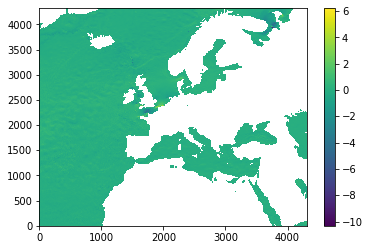

In [153]:
plt.pcolormesh(i,j,vals_U_kt0)
plt.colorbar()
plt.show()

## *Conversión de índices (i,j) a (longitud,latitud)

Necesitamos "convertir" los índices (i,j) a (lon,lat)

La cara 2 tiene los siguientes rangos (aproximados):
 - Longitud: -35 a 55 (90 grados)
 - Latitud: 13.5 a 71 (57.5 grados)
 
\* Ya no será necesario. Ir a siguiente sección

In [24]:
%%script false 
# La longitud es sencilla de convertir
min_lon = -35
lon = min_lon+i/map_res

lon_i = ((lon_,i_,1/map_res) for lon_,i_ in zip(lon,i))
lon_i_df = pd.DataFrame(lon_i,columns=["lon","i","d_lon"])
lon_i_df.set_index("lon",inplace=True)
#lon_i_df.head()

In [25]:
%%script false 
min_lat = 13.5
#max_lat = 71 # Algo así deberíamos de obtener en max(lat)
lat = np.zeros((len(j),))
lat[0] = min_lat
del_lat = np.zeros((len(j),))
del_lat[0] = np.cos(min_lat*np.pi/180)/map_res
for jj in range(1,len(j)):
    del_lat[jj] = np.cos(lat[jj-1]*np.pi/180)/map_res
    lat[jj] = lat[jj-1] + del_lat[jj]
print(min(lat))
print(max(lat))

lat_j = ((lat_,j_,dlat) for lat_,j_,dlat in zip(lat,j,del_lat))
lat_j_df = pd.DataFrame(lat_j,columns=["lat","j","d_lat"])
lat_j_df.set_index("lat",inplace=True)

## Leyendo (lon,lat) directamente de la malla 1/24


In [26]:
from xmitgcm import open_mdsdataset

In [72]:
grid_ds = open_mdsdataset('/home/antonio/GoogleDrive/LLC2160/grid/', read_grid=True, iters=None, default_dtype=np.float32, geometry='llc')


NameError: name 'open_mdsdataset' is not defined

In [73]:
grid_ds
#grid_ds.Zl.values ## z=-500 m está en el índice 40

NameError: name 'grid_ds' is not defined

In [29]:
print("Fetching grid lon")
LON_24 = grid_ds.XG.isel(face=2).values
print("Fetching grid lat")
LAT_24 = grid_ds.YG.isel(face=2).values
print("Fetching grid depth")
DEPTH_24 = grid_ds.Depth.isel(face=2).values

Fetching grid lon
Fetching grid lat
Fetching grid depth


In [30]:
print(LAT_24.shape)
print(LON_24.shape)
print(DEPTH_24.shape)

(2160, 2160)
(2160, 2160)
(2160, 2160)


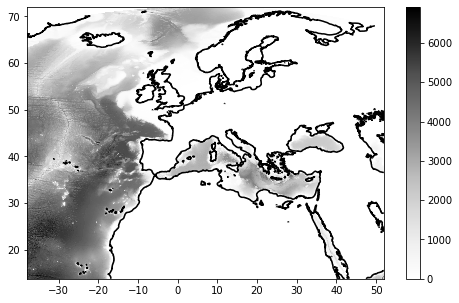

In [31]:
plt.figure(figsize=(8,5))
plt.contour(LON_24,LAT_24,DEPTH_24,[0],colors='black')
_c = plt.pcolormesh(LON_24,LAT_24,DEPTH_24,cmap=plt.cm.Greys)
plt.colorbar(_c)
plt.show()

### Interpolamos de la resolución de la malla 1/24 a 1/48

In [32]:
from scipy.interpolate import interp2d

def interpmat_48(grid_mat):
    # Old
    nrow,ncol = grid_mat.shape
    rows = np.arange(nrow)
    cols = np.arange(ncol)
    interp = interp2d(cols,rows,grid_mat,kind='cubic')
    # New 
    new_r = np.arange(nrow*2)/2
    new_c = np.arange(ncol*2)/2
    return interp(new_c,new_r)

In [33]:
LAT_48 = interpmat_48(LAT_24)
LON_48 = interpmat_48(LON_24)
DEPTH_48 = interpmat_48(DEPTH_24)

In [34]:
print(LON_48.shape)
print(LAT_48.shape)
print(DEPTH_48.shape)

(4320, 4320)
(4320, 4320)
(4320, 4320)


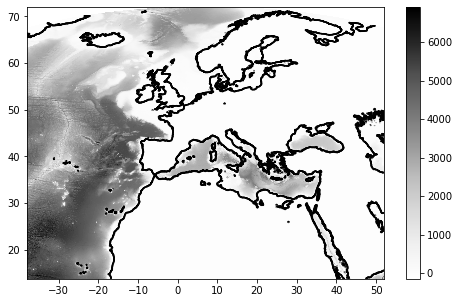

In [35]:
plt.figure(figsize=(8,5))
plt.contour(LON_48,LAT_48,DEPTH_48,[0.1],colors='black')
_c = plt.pcolormesh(LON_48,LAT_48,DEPTH_48,cmap=plt.cm.Greys)
plt.colorbar(_c)
plt.show()

#### Ejemplo: Graficamos la velocidad U con ambas resoluciones

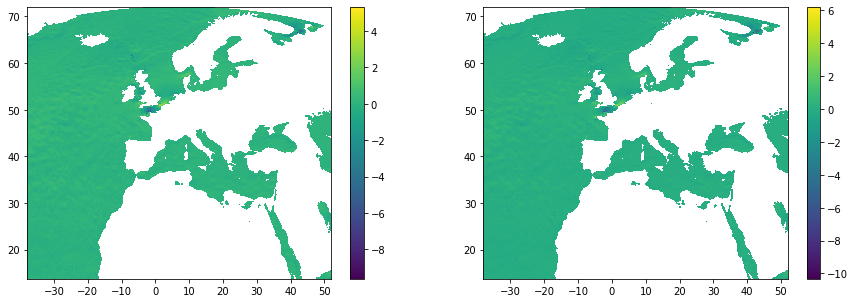

In [154]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
_c1 = ax1.pcolormesh(LON_24,LAT_24,vals_U_kt0[::2,::2])
_c2 = ax2.pcolormesh(LON_48,LAT_48,vals_U_kt0)
fig.colorbar(_c1,ax=ax1)
fig.colorbar(_c2,ax=ax2)
fig.show()

### Trabajando con datos en las celdas 7-12

In [156]:
##%%script false
## Experimental solamente
cell=10
if cell<=6:
    print("No rot")
else:
    print("rot")

rot


In [157]:
##%%script false
## Experimental solamente
print("Fetching grid lon")
LON_24_ = np.rot90(grid_ds.XG.isel(face=cell).values)
print("Fetching grid lat")
LAT_24_ = np.rot90(grid_ds.YG.isel(face=cell).values)

LON_48_ = interpmat_48(LON_24_)
LAT_48_ = interpmat_48(LAT_24_)

Fetching grid lon
Fetching grid lat


In [158]:
##%%script false
## Experimental solamente
DY_24_ = np.rot90(grid_ds.dyG.isel(face=cell).values)
DX_24_ = np.rot90(grid_ds.dxG.isel(face=cell).values)

DY_48_ = interpmat_48(DY_24_/2)
DX_48_ = interpmat_48(DX_24_/2)

In [160]:
##%%script false
## Experimental solamente
ds_ = model.get_dataset(varnames=vars_wf,k_chunksize=1,type=map_mode,iter_step=144*24).isel(face=cell) # 144 iters = 1 hr
vals_u_ = ds_.U.isel(time=0,k=0).values

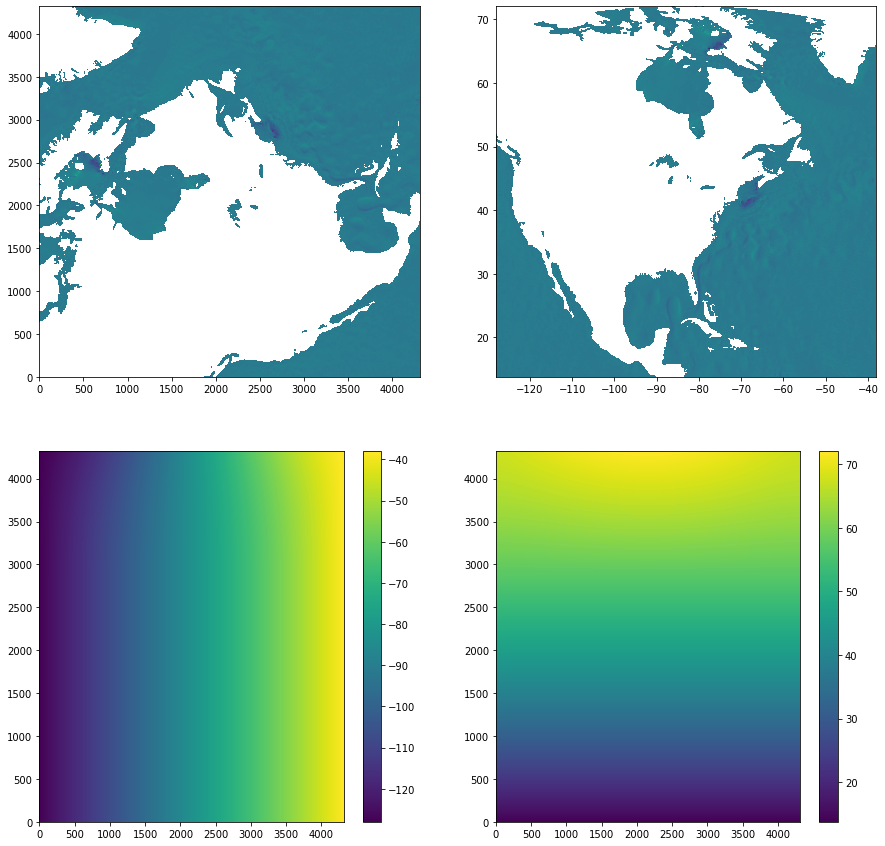

In [161]:
##%%script false
## Experimental solamente
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
ax1.pcolormesh(vals_u_)
dat_ = np.rot90(vals_u_)
ax2.pcolormesh(LON_48_,LAT_48_,dat_)
c_lon = ax3.pcolormesh(LON_48_)
c_lat = ax4.pcolormesh(LAT_48_)
fig.colorbar(c_lon,ax=ax3)
fig.colorbar(c_lat,ax=ax4)

plt.show()

#### Tomando una sección de la celda

In [169]:
##%%script false
## Experimental solamente
min_i,min_j = find_ij_4lonlat(-128,29.09675,LON_48_,LAT_48_)
max_i,max_j = find_ij_4lonlat(-122,33.82725,LON_48_,LAT_48_)
#min_i,min_j = find_ij_4lonlat(-120,15,LON_48_,LAT_48_)
#max_i,max_j = find_ij_4lonlat(-80,55,LON_48_,LAT_48_)
max_i = max_i+1
max_j = max_j+1
#min_i,min_j,max_i,max_j = 3456,0,3744,289
#min_i,min_j,max_i,max_j = 3166,0,3457,289

i_slice = slice(min_i,max_i)
j_slice = slice(min_j,max_j)
print(min_i,min_j,max_i,max_j)

print("Esquina inferior izquierda",LON_48_[min_j,min_i],LAT_48_[min_j,min_i])
print("Esquina superior derecha",LON_48_[max_j,max_i],LAT_48_[max_j,max_i])

0 862 289 1153
Esquina inferior izquierda -128.00000000000003 29.088457107543952
Esquina superior derecha -121.97916889190674 33.84638561715301


In [173]:
##%%script false
## Experimental solamente
LON__ = LON_48_[min_j:max_j,min_i:max_i]
LAT__ = LAT_48_[min_j:max_j,min_i:max_i]
DX__ = DX_48_[min_j:max_j,min_i:max_i]
DY__ = DY_48_[min_j:max_j,min_i:max_i]

ds__ = model.get_dataset(varnames=vars_wf,k_chunksize=1,type=map_mode,iter_step=144*24).isel(face=cell,time=0,k=0) # 144 iters = 1 hr
vals_u__ = np.rot90(ds__.U.values)[min_j:max_j,min_i:max_i]
vals_v__ = np.rot90(ds__.V.values)[min_j:max_j,min_i:max_i]
rv__ = rv_(vals_u__,vals_v__,DX__,DY__)
divnorm__ = colors.DivergingNorm(vmin=np.min(rv__), vcenter=0, vmax=np.max(rv__))

print(LON__.shape)
print(LAT__.shape)
print(DX__.shape)
print(DY__.shape)
print(vals_u__.shape)

(291, 289)
(291, 289)
(291, 289)
(291, 289)
(291, 289)


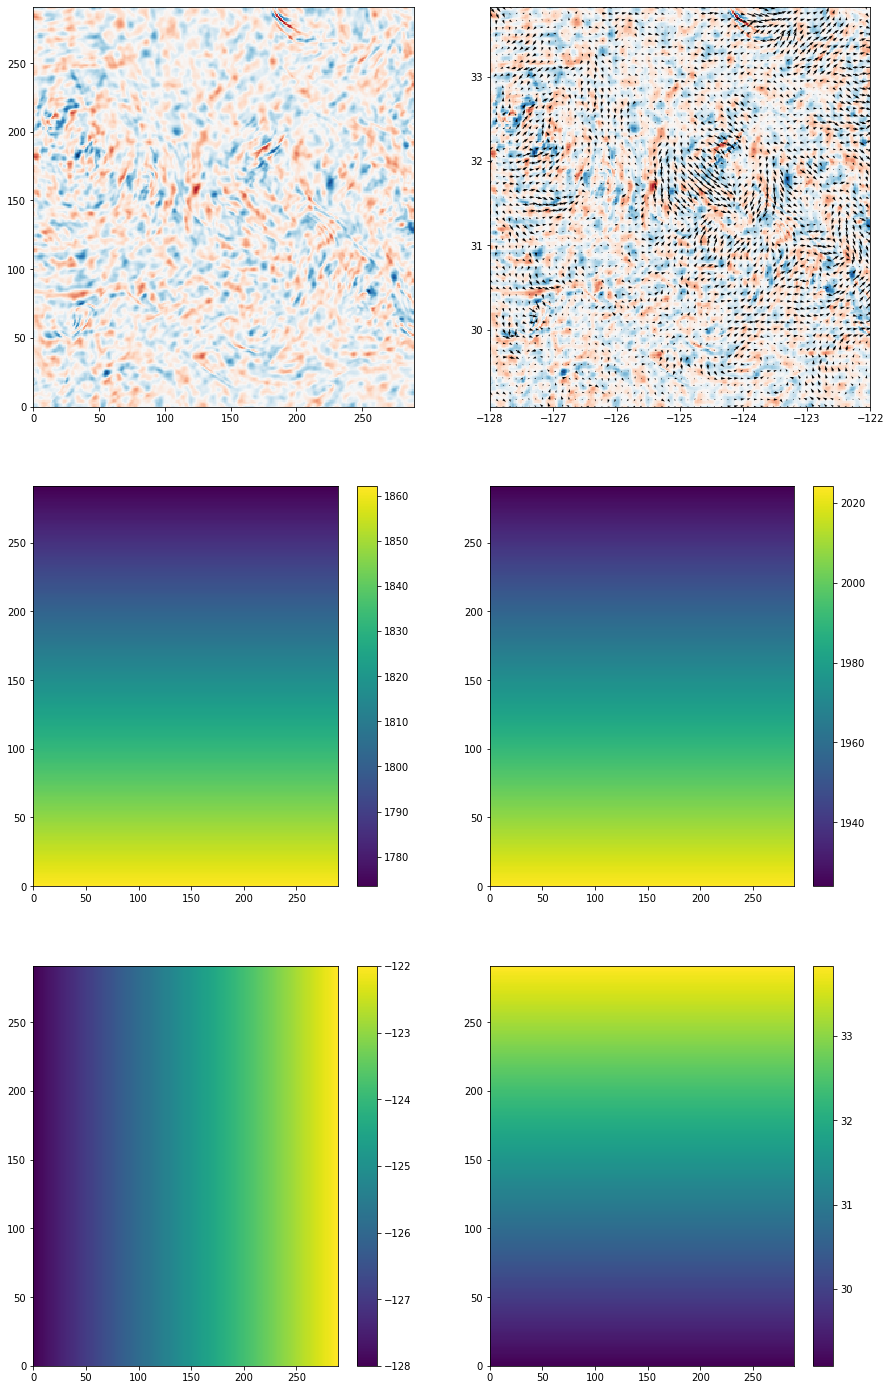

In [177]:
##%%script false
## Experimental solamente
fig = plt.figure(figsize=(15,25))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)
nn_ = 5
_c1 = ax1.pcolormesh(rv__,norm=divnorm__,cmap=plt.cm.RdBu)

#ax1.quiver(vals_u__[::nn_,::nn_],vals_v__[::nn_,::nn_])
ax2.pcolormesh(LON__,LAT__,rv__,norm=divnorm__,cmap=plt.cm.RdBu)
ax2.quiver(LON__[::nn_,::nn_],LAT__[::nn_,::nn_],vals_u__[::nn_,::nn_],vals_v__[::nn_,::nn_])
_c3 = ax3.pcolormesh(DX__)
_c4 = ax4.pcolormesh(DY__)
_c5 = ax5.pcolormesh(LON__)
_c6 = ax6.pcolormesh(LAT__)
fig.colorbar(_c3,ax=ax3)
fig.colorbar(_c4,ax=ax4)
fig.colorbar(_c5,ax=ax5)
fig.colorbar(_c6,ax=ax6)
plt.show()

### Estimando el tamaño cada diferencial de malla

#### Interpolamos dx,dy

In [46]:
DY_24 = grid_ds.dyG.isel(face=2).values
DX_24 = grid_ds.dxG.isel(face=2).values
print(DY_24.shape)
print(DX_24.shape)

(2160, 2160)
(2160, 2160)


In [47]:
DY_48 = interpmat_48(DY_24/2)
DX_48 = interpmat_48(DX_24/2)
print(DY_48.shape)
print(DX_48.shape)

(4320, 4320)
(4320, 4320)


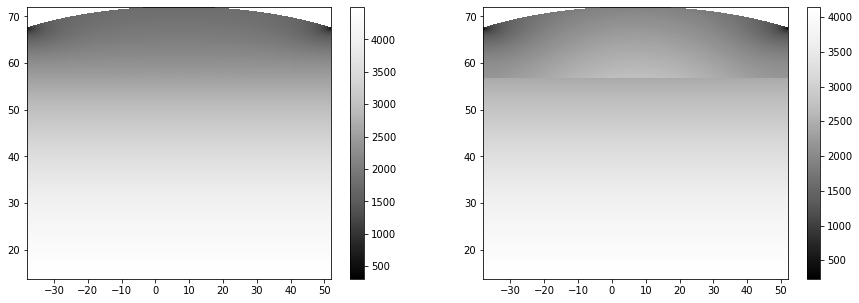

In [48]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
_c1 = ax1.pcolormesh(LON_24,LAT_24,DX_24,cmap=plt.cm.Greys_r)
_c2 = ax2.pcolormesh(LON_24,LAT_24,DY_24,cmap=plt.cm.Greys_r)
fig.colorbar(_c1,ax=ax1)
fig.colorbar(_c2,ax=ax2)
fig.show()

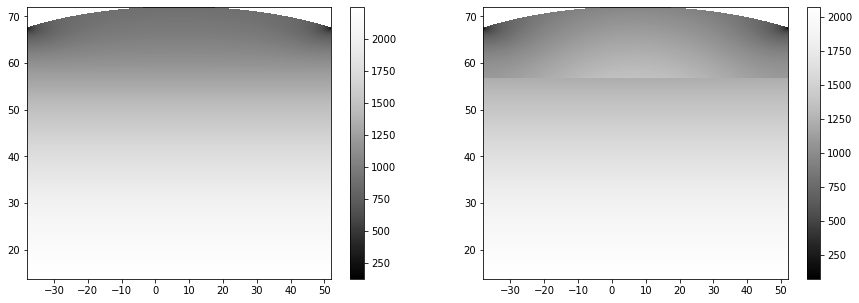

In [49]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
_c1 = ax1.pcolormesh(LON_48,LAT_48,DX_48,cmap=plt.cm.Greys_r)
_c2 = ax2.pcolormesh(LON_48,LAT_48,DY_48,cmap=plt.cm.Greys_r)
fig.colorbar(_c1,ax=ax1)
fig.colorbar(_c2,ax=ax2)
fig.show()

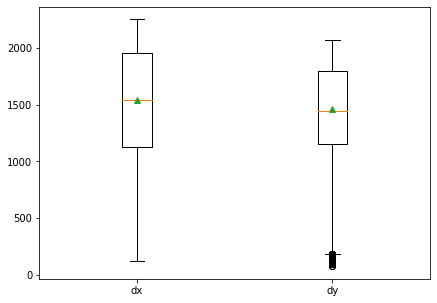

In [50]:
# Graficamos la distribución de dx y dy en la cara 2
plt.figure(figsize=(7,5))
dx48_vec = DX_48.flatten()
dy48_vec = DY_48.flatten()
plt.boxplot([dx48_vec,dy48_vec],showmeans=True,labels=["dx","dy"])
plt.show()

## Seleccionamos la región que usaremos (caja)

In [51]:
area_id = 730

# Directorio de los datos geográficos
prnt_map = '/home/antonio/GoogleDrive/Tesis/spectral_analysis/map_data'
geodata = gpd.read_file('{}/{}_{}_geo.json'.format(prnt_map,'RV',"ASO"),driver='GeoJSON')
data_area = geodata[geodata["s_id"]==area_id].drop(columns=["season","var"])
area_box = data_area['geometry'].values[0]
lon_min,lat_min,lon_max,lat_max = area_box.bounds

# ** Si no podemos leerlo (desde GDrive o local), metemos los datos a mano
#lon_min,lat_min,lon_max,lat_max = (-26.0, 29.096750000000014, -20.0, 33.827249999999985)

print(lon_min,lat_min,lon_max,lat_max)

-26.0 19.03675000000002 -20.0 24.185249999999982


### Buscando los índices para seleccionar la región

In [52]:
%%script false
i_area = lon_i_df[lon_min:lon_max]["i"].values
j_area = lat_j_df[lat_min:lat_max]["j"].values
lon_area = lon_i_df[lon_min:lon_max].index.values
lat_area = lat_j_df[lat_min:lat_max].index.values

min_i = i_area[0]
max_i = i_area[-1]
min_j = j_area[0]
max_j = j_area[-1]

In [53]:
def find_ij_4lonlat(lon_v,lat_v,lon,lat):
    # (lon_v,lat_v): Valores de [lon,lat] a buscar
    # (lon,lat): Matrices con latitud y longitud en donde buscaremos
    # Regresa: Índices i(lon),j(lat) correspondientes al punto más cercano a (lon_v,lat_v)
    # Hacemos la búsqueda con el punto R2 = (lon-lon_v)^2 + (lat-lat_v)^2, tal que R2 sea mínimo
    R2 = np.square(lon-lon_v) + np.square(lat-lat_v)
    found = np.where(R2==np.amin(R2))
    # Para xmitgcm, los índices están invertidos: i=eje x (columnas), j=eje y (filas)
    j = found[0][0]
    i = found[1][0]
    return i,j

In [54]:
## Esquina inferior izquierda
print(lon_min,lat_min)
min_i,min_j = find_ij_4lonlat(lon_min,lat_min,LON_48,LAT_48)
print(min_i,min_j)
print(LON_48[min_j,min_i],LAT_48[min_j,min_i])

## Esquina superior derecha
print(lon_max,lat_max)
max_i,max_j = find_ij_4lonlat(lon_max,lat_max,LON_48,LAT_48)
#print(max_i,max_j)
print(LON_48[max_j,max_i],LAT_48[max_j,max_i])
# slice(start:end) y np.array[start:end] no incluyen el punto final
max_i = max_i+1
max_j = max_j+1
print(max_i,max_j)

-26.0 19.03675000000002
576 288
-26.0 19.032817840576172
-20.0 24.185249999999982
-20.000000000000004 24.176759957937925
865 578


### Seleccionamos las coordenadas del área, así como dx,dy

In [55]:
lat_area = LAT_48[min_j:max_j,min_i:max_i]
lon_area = LON_48[min_j:max_j,min_i:max_i]
dx_area = DX_48[min_j:max_j,min_i:max_i]
dy_area = DY_48[min_j:max_j,min_i:max_i]

In [56]:
print(lat_area.shape)
print(lon_area.shape)
print(dx_area.shape)
print(dy_area.shape)

(290, 289)
(290, 289)
(290, 289)
(290, 289)


In [57]:
cos_lat = np.cos(lat_area*np.pi/180)
sin_lat = np.sin(lat_area*np.pi/180)

In [58]:
%%script false
cos_lat = np.tile(np.cos(lat_area*np.pi/180).reshape((len(j_area),1)),(1,len(i_area)))
sin_lat = np.tile(np.sin(lat_area*np.pi/180).reshape((len(j_area),1)),(1,len(i_area)))

R = 6371*1000 # Radio de la Tierra, en metros
C = 2*np.pi*R # Circunferencia en el Ecuador
DX = C*cos_lat/map_res/360
DY = dx

### Necesitamos los valores k para z=0 y z=400 m

In [59]:
z_grid = np.abs(grid_ds.Zl.values)
# z=0
k0 = 0
print(k0, z_grid[k0])
# z=H=400 m
HH = 400
Z_H = np.abs(z_grid-HH)
found_k = np.where(Z_H==np.amin(Z_H))
kH = found_k[0][0] # Coordenada i (0) del primer elemento (0)
print(kH,z_grid[kH])
k_lvl_wf = [k0,kH]       # Índices correspondientes a la profundidad a la que operaremos
print(k_lvl_wf)

0 0.0
36 395.29
[0, 36]


### Tomamos los datos para el área

In [60]:
ds_area = ds.isel(i=slice(min_i,max_i),j=slice(min_j,max_j),
                  i_g=slice(min_i,max_i),j_g=slice(min_j,max_j),
                  k=k_lvl_wf
                  )
ds_area

<xarray.Dataset>
Dimensions:  (i: 289, i_g: 289, j: 290, j_g: 290, k: 2, k_l: 90, k_p1: 90, k_u: 90, time: 377)
Coordinates:
    face     int64 10
  * i        (i) int64 576 577 578 579 580 581 582 ... 859 860 861 862 863 864
  * i_g      (i_g) int64 576 577 578 579 580 581 582 ... 859 860 861 862 863 864
  * j        (j) int64 288 289 290 291 292 293 294 ... 572 573 574 575 576 577
  * j_g      (j_g) int64 288 289 290 291 292 293 294 ... 572 573 574 575 576 577
  * k        (k) int64 0 36
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-23
Data variables:
    U        (time, k, j, i_g) >f4 dask.array<chunksize=(1, 1, 290, 289), meta=np.ndarray>
    V        (time, k, j_g, i) >f4 dask.array<chunksize=(1

In [61]:
ds_area.nbytes/(1024**3)

0.47083888202905655

In [62]:
len(ds_area.time.values)

377

## Vorticidad planetaria (f) en la región

In [63]:
# Parámetro de coriolis: f = 2*Omega*cos(latitud)
Omega = 2*np.pi/(24*3600) # Frecuencia de rotación terrestre
f_cor = 2*Omega*sin_lat

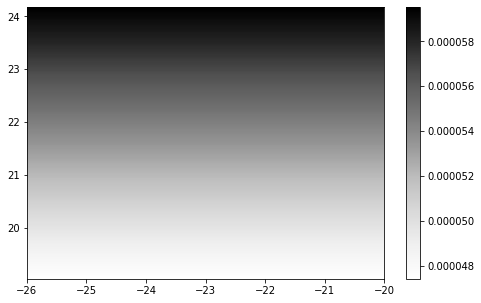

In [64]:
plt.figure(figsize=(8,5))
#plt.contour(lon_area,lat_area,f_cor)
_c = plt.pcolormesh(lon_area,lat_area,f_cor,cmap=plt.cm.Greys)
plt.colorbar(_c)
plt.show()

## Ejemplo: Vorticidad relativa en la región (t=0, z=0)

In [65]:
vals_u = ds_area.U.isel(time=0,k=0).values
vals_u.shape

(290, 289)

In [66]:
vals_v = ds_area.V.isel(time=0,k=0).values
vals_v.shape

(290, 289)

In [67]:
def rv(u,v):
    return (np.gradient(v,axis=-1,edge_order=2)/dx_area) - (np.gradient(u,axis=-2,edge_order=2)/dy_area)

In [68]:
RV_0 = rv(vals_u,vals_v)

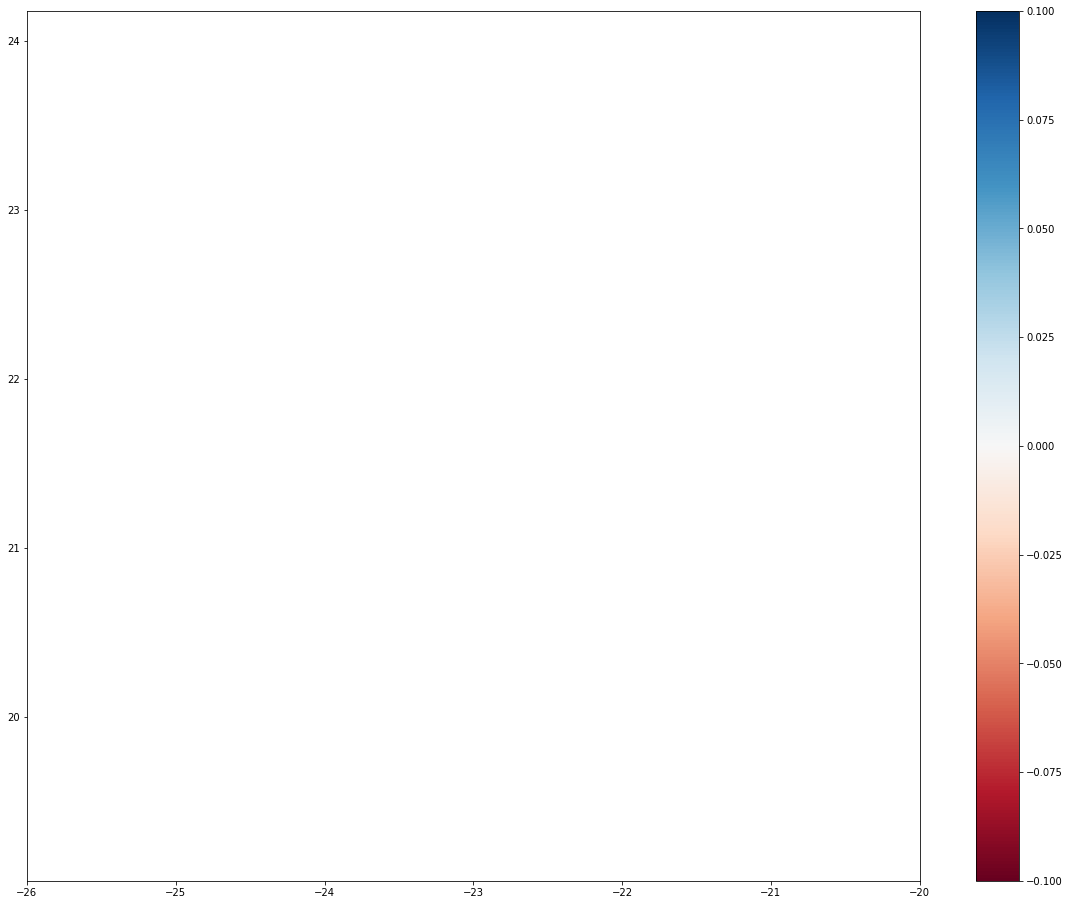

In [69]:
plt.figure(figsize=(20,16))
divnorm = colors.DivergingNorm(vmin=np.min(RV_0), vcenter=0, vmax=np.max(RV_0))

nn=3
_cs = plt.pcolormesh(lon_area,lat_area,RV_0,norm=divnorm,cmap=plt.cm.RdBu) # plt.cm.RdBu
plt.colorbar(_cs)
plt.quiver(lon_area[::nn,::nn],lat_area[::nn,::nn],vals_u[::nn,::nn],vals_v[::nn,::nn],color='gray')
plt.show()

## Funciones para filtrar movimientos cortos y largos

### Transformada de Fourier directa e inversa (FFT, IFFT)

Ver [pregunta en SO](https://dsp.stackexchange.com/questions/724/low-pass-filter-and-fft-for-beginners-with-python/725#725) para información sobre consideraciones en el uso de un filtro "ideal"

#### Intervalos de "muestreo"

Las funciones como FFT dan por hecho que estamos muestreando a intervalos regulares.

En el caso de la trasnformada de Fourier espacial en (x,y), suponemos que tanto dx como dy son constantes. Esto no es en general cierto para una esfera, pero si la variación no es muy significativa, podemos usar FFT como buena aproximación, ya que de lo contrario tendríamos que interpolar a una malla regular, hacer el filtrado, y de nuevo interpolar a la malla original, lo que podría inducir mayor ruido.

In [70]:
%%script false
max_dx = np.max(dxdy)
min_dx = np.min(dxdy)
print(max_dx)
print(min_dx)
print("Diferencia entre intervalos de muestreo: {0:.2f}%".format(100*(max_dx-min_dx)/max_dx))
# Esta diferencia porcentual nos permite hacer la FFT como si los puntos estuvieran en una malla cuadriculada
dxdy_avg = (max_dx + min_dx)/2
print("Usaremos un delta_xy promedio de {0:.3f} km".format(dxdy_avg/1000))

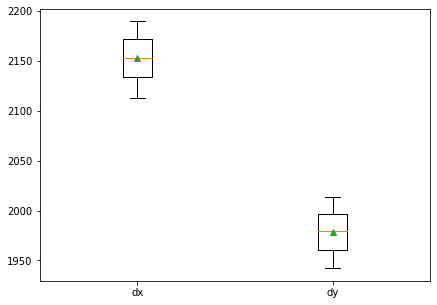

In [71]:
# Graficamos la distribución de dx y dy en el área
plt.figure(figsize=(7,5))
dx_vec = dx_area.flatten()
dy_vec = dy_area.flatten()
plt.boxplot([dx_vec,dy_vec],showmeans=True,labels=["dx","dy"])
plt.show()

In [72]:
# Como puede verse, la variación es relativamente poca
max_dx = np.max(dx_vec)
min_dx = np.min(dx_vec)
dx_avg = np.mean(dx_vec)
print("Diferencia entre intervalos de muestreo en x: {0:.2f}%".format(100*(max_dx-min_dx)/max_dx))
print("Tenemos un dx promedio de {0:.3f} km".format(dx_avg/1000))
max_dy = np.max(dy_vec)
min_dy= np.min(dy_vec)
dy_avg = np.mean(dy_vec)
print("Diferencia entre intervalos de muestreo en y: {0:.2f}%".format(100*(max_dy-min_dy)/max_dy))
print("Tenemos un dy promedio de {0:.3f} km".format(dy_avg/1000))

Diferencia entre intervalos de muestreo en x: 3.50%
Tenemos un dx promedio de 2.153 km
Diferencia entre intervalos de muestreo en y: 3.55%
Tenemos un dy promedio de 1.979 km


#### FFT-IFFT

In [73]:
Nx = lon_area.shape[1]
Lx = Nx*dx_avg
delta_kx = 1/Lx
Ny = lon_area.shape[0]
Ly = Ny*dy_avg
delta_ky = 1/Ly

print("Se hace la FFT en una región cuadrangular de ~ {0:.2f} x {1:.2f} km, o {2}x{3} puntos".format(Lx/1000,Ly/1000,Nx,Ny))

Se hace la FFT en una región cuadrangular de ~ 622.08 x 573.80 km, o 289x290 puntos


In [74]:
N_kx = (Nx-1)/2
Kx = delta_kx*np.arange(-N_kx,N_kx+1)
N_ky = (Ny-1)/2
Ky = delta_ky*np.arange(-N_ky,N_ky+1)
print(len(Kx))
print(len(Ky))
print(1/(delta_kx*N_kx)) # Longitud de onda maxima mostrada en el espacio K (# de onda)

289
290
4319.98158785847


In [10]:
def kxky(dx,dy,shape):
    Ny,Nx = shape[-2:]
    Lx = Nx*dx
    Ly = Ny*dy
    delta_kx = 1/Lx
    delta_ky = 1/Ly
    N_kx = (Nx-1)/2
    N_ky = (Ny-1)/2
    Kx = delta_kx*np.arange(-N_kx,N_kx+1)
    Ky = delta_ky*np.arange(-N_ky,N_ky+1)
    return np.meshgrid(Kx,Ky)

In [11]:
def create_filter_k(Lt=50*1000,order=0,k_=None,flip=False): #Orden 0 es el filtro ideal, de 1 de adelante es el Butterworth
    K_max = 1/Lt
    kx_,ky_ = np.meshgrid(Kx,Ky) if k_ is None else k_
    
    if order==0:
        filter_mask_plt = (np.square(kx_)+np.square(ky_) <= K_max**2).astype(np.float32)
    else:
        with np.errstate(over='ignore'):
            filter_mask_plt = 1/( 1 + ( (np.square(kx_)+np.square(ky_))/(K_max**2) )**order )
    
    filter_mask = np.fft.fftshift(filter_mask_plt)
    
    if flip:
        filter_mask = filter_mask*np.fliplr(filter_mask) # Simetria en Kx
        filter_mask = filter_mask*np.flipud(filter_mask) # Simetria en Ky
    
    return filter_mask

In [12]:
# Por defecto, filtra a 50 km
def filter_fft(var_xy,Lt=50*1000):
    var_k = np.fft.fft2(var_xy)

    # Las variables _plt solo se usan de forma auxiliar para las gráficas (plot)
    filter_mask = create_filter_k(Lt=Lt,flip=True)
    
    # El cálculo de la inversa se hará sobre la variable a la que no se le aplica fftshift,
    # ya que np.flipup y np.fliplr no conmutan con fftshift
    var_k_lo = var_k*filter_mask
    _var_lo = np.fft.ifft2(var_k_lo)
    
    # Eliminamos la parte imaginaria, ya que es espuria
    var_lo = np.real(_var_lo)
    var_hi = var_xy-var_lo
    
    return var_lo,var_hi

In [13]:
## Filtro de Butterworth
## Por defecto, filtra a 50 km
def filter_fft_butterworth(var_xy,Lt=50*1000,dx=None,dy=None,order=100):
    var_k = np.fft.fft2(var_xy)
    
    if (dx is None) or (dy is None):
        dx = dx_avg
        dy = dy_avg
    
    k_ = kxky(dx,dy,var_xy.shape)
    filter_mask = create_filter_k(Lt=Lt,order=order,k_=k_)
    
    # El cálculo de la inversa se hará sobre la variable a la que no se le aplica fftshift,
    # ya que np.flipup y np.fliplr no conmutan con fftshift
    var_k_lo = var_k*filter_mask
    _var_lo = np.fft.ifft2(var_k_lo)
    
    # Eliminamos la parte imaginaria, ya que es espuria
    var_lo = np.real(_var_lo)
    var_hi = var_xy-var_lo
    
    return var_lo,var_hi

### Comparamos ambos filtros

#### Primero en el espacio K

In [ ]:
from matplotlib.colors import LogNorm,PowerNorm

filter_ideal = np.fft.fftshift(create_filter_k())[int(Nx/3):int(2*Nx/3),int(Ny/3):int(2*Ny/3)]
filter_butterworth = np.fft.fftshift(create_filter_k(order=100))[int(Nx/3):int(2*Nx/3),int(Ny/3):int(2*Ny/3)]

kx_,ky_ = np.meshgrid(Kx,Ky)
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax = ax.flat[:]
kxx = kx_[int(Nx/3):int(2*Nx/3),int(Ny/3):int(2*Ny/3)]
kyy = ky_[int(Nx/3):int(2*Nx/3),int(Ny/3):int(2*Ny/3)]

plt.sca(ax[0])
plt.pcolormesh(kxx,kyy,filter_ideal)
plt.colorbar()
plt.sca(ax[1])
plt.pcolormesh(kxx,kyy,filter_butterworth)
plt.colorbar()
plt.sca(ax[2])
filter_diff = filter_butterworth-filter_ideal
divnorm_diff_fk = colors.DivergingNorm(vmin=np.min(filter_diff), vcenter=0, vmax=np.max(filter_diff))
plt.pcolormesh(kxx,kyy,filter_diff,norm=divnorm_diff_fk,cmap=plt.cm.RdBu)
plt.colorbar()

fig.show()

#### Luego el resultado de aplicarlos en el espacio xy

In [ ]:
# Ideal filter
u_lo_filt_ideal,u_hi_filt_ideal = filter_fft(vals_u)
v_lo_filt_ideal,v_hi_filt_ideal = filter_fft(vals_v)
rv_lo_ideal = rv(u_lo_filt_ideal,v_lo_filt_ideal)
rv_hi_ideal = rv(u_hi_filt_ideal,v_hi_filt_ideal)
# Butterworth filter
u_lo_filt_bw,u_hi_filt_bw = filter_fft_butterworth(vals_u)
v_lo_filt_bw,v_hi_filt_bw = filter_fft_butterworth(vals_v)
rv_lo_bw = rv(u_lo_filt_bw,v_lo_filt_bw)
rv_hi_bw = rv(u_hi_filt_bw,v_hi_filt_bw)

min_rv = min(np.min(rv_lo_ideal),np.min(rv_hi_ideal),np.min(rv_lo_bw),np.min(rv_hi_bw))
max_rv = max(np.max(rv_lo_ideal),np.max(rv_hi_ideal),np.max(rv_lo_bw),np.max(rv_hi_bw))
divnorm_all = colors.DivergingNorm(vmin=min_rv, vcenter=0, vmax=max_rv)
fig, ax = plt.subplots(3,2,figsize=(15,20))

plt.sca(ax[0][0])
plt.pcolormesh(lon_area,lat_area,rv_lo_ideal,norm=divnorm_all,cmap=plt.cm.RdBu)
plt.colorbar()
plt.sca(ax[0][1])
plt.pcolormesh(lon_area,lat_area,rv_hi_ideal,norm=divnorm_all,cmap=plt.cm.RdBu)
plt.colorbar()
plt.sca(ax[1][0])
plt.pcolormesh(lon_area,lat_area,rv_lo_bw,norm=divnorm_all,cmap=plt.cm.RdBu)
plt.colorbar()
plt.sca(ax[1][1])
plt.pcolormesh(lon_area,lat_area,rv_hi_bw,norm=divnorm_all,cmap=plt.cm.RdBu)
plt.colorbar()
plt.sca(ax[2][0])
plt.pcolormesh(lon_area,lat_area,rv_lo_ideal-rv_lo_bw,cmap=plt.cm.RdBu)
plt.colorbar()
plt.sca(ax[2][1])
plt.pcolormesh(lon_area,lat_area,rv_hi_ideal-rv_hi_bw,cmap=plt.cm.RdBu)
plt.colorbar()

plt.show()

In [ ]:
%%script false # Uncomment to test
## Practicamos escritura y lectura de datos
fname = "/tmp/file0.dat"
np.savetxt(fname,lat_area,fmt='%s')
print(lat_area.shape)
lat_AA = np.loadtxt(fname)
print(lat_AA.shape)

## Workflow

### Función que calcula Ro_b, así como sus componentes de alta y baja frecuencia

In [ ]:
from netCDF4 import Datasetdef Ro_b_filter(ds_area,t,Lt=50*1000):
    ds_area_t = ds_area.isel(time=t)
    print(t,ds_area_t.nbytes/(1024**3))
    
    print("U,V")
    # Obtenemos U en z=0
    u0 = ds_area_t.U.isel(k=0).values
    # Obtenemos V en z=0
    v0 = ds_area_t.V.isel(k=0).values
    # Calculamos RV en z=0
    RV_0 = (np.gradient(v0,axis=1)/dx_area) - (np.gradient(u0,axis=0)/dy_area)
    # Filtramos y calculamos RV
    print ("Filter 0")
    u0_lo,u0_hi = filter_fft(u0,Lt)
    del u0
    v0_lo,v0_hi = filter_fft(v0,Lt)
    del v0
    print("RV_0")
    rv0_hi = (np.gradient(v0_hi,axis=1)/dx_area) - (np.gradient(u0_hi,axis=0)/dy_area)
    del u0_hi,v0_hi
    rv0_lo = (np.gradient(v0_lo,axis=1)/dx_area) - (np.gradient(u0_lo,axis=0)/dy_area)
    del u0_lo,v0_lo
    
    # Obtenemos U en z=H
    uH = ds_area_t.U.isel(k=1).values
    # Obtenemos V en z=H
    vH = ds_area_t.V.isel(k=1).values
    # Calculamos RV en z=0
    RV_H = (np.gradient(vH,axis=1)/dx_area) - (np.gradient(uH,axis=0)/dy_area)
    # Filtramos y calculamos RV
    print("Filter H")
    uH_lo,uH_hi = filter_fft(uH,Lt)
    del uH
    vH_lo,vH_hi = filter_fft(vH,Lt)
    del Vh
    print("RV_H")
    rvH_hi = (np.gradient(vH_hi,axis=1)/dx_area) - (np.gradient(uH_hi,axis=0)/dy_area)
    del uH_hi,vH_hi
    rvH_lo = (np.gradient(vH_lo,axis=1)/dx_area) - (np.gradient(uH_lo,axis=0)/dy_area)
    del uH_lo,vH_lo

    print("Ro_b")
    # ... y finalmente el Número de Rossby baroclínico (Ro_b)
    Ro_b = np.abs((RV_0-RV_H)/f_cor)
    #print(np.max(Ro_b))
    Rob_lo = np.abs((rv0_lo-rvH_lo)/f_cor)
    Rob_hi = np.abs((rv0_hi-rvH_hi)/f_cor)
    #print(np.max(Rob_lo),np.max(Rob_hi))
    
    return (Ro_b,Rob_lo,Rob_hi)

### Versión script plano

In [ ]:
for time_ds in range(len(ds.time.values)):
    Ro_b_filter(ds_area,time_ds)

### Versión Luigi

In [ ]:
import luigi
from luigi import Task,LocalTarget,IntParameter
import multiprocessing
from netCDF4 import Dataset

In [ ]:
prnt = "/home/antonio/GoogleDrive/Tesis/Rob_kfiltered"
Lt = 75*1000 # Partimos en 75 km
class RossbyB(Task):
    t = IntParameter()
    _target = None
    
    def output(self):
        if self._target is None:
            self._target = LocalTarget("{}/Rob_{:05d}.nc".format(prnt,self.t))
        return self._target
    
    def run(self):
        Ro_b,Rob_lo,Rob_hi = Ro_b_filter(ds_area,self.t,Lt=Lt)
        fn_out = self.output().fn
        print("Saving to {}".format(fn_out))
        nc = Dataset(fn_out,'w','NETCDF3')
        nlon,nlat=lon_area.shape
        nc.createDimension('nlon',nlon)
        nc.createDimension('nlat',nlat)
        nc.createDimension('time',None)   # Solo ponemos un tiempo
        # Coordenadas
        nlon_v = nc.createVariable('nlon','int',('nlon'))
        nlon_v = np.arange(nlon)
        nlat_v = nc.createVariable('nlat','int',('nlat'))
        nlat_v = np.arange(nlat)
        # Variables 
        time_v = nc.createVariable('time','int',('time'))
        time_v.setncattr('units','Hours since 2011-09-13T00:00:00')
        time_v = self.t
        lon_v = nc.createVariable('lon','float32',('time','nlon','nlat'))
        time_v.setncattr('units','degrees')
        lon_v[:] = lon_area
        lat_v = nc.createVariable('lat','float32',('time','nlon','nlat'))
        time_v.setncattr('units','degrees')
        lat_v[:] = lat_area
        # RV
        Rob_v = nc.createVariable('Rob','float32',('time','nlon','nlat'))
        Rob_v.setncatts({'units':'s^-1','description':"RV for all wavelenghts"})
        Rob_hi_v = nc.createVariable('Rob_Hi','float32',('time','nlon','nlat'))
        Rob_hi_v.setncatts({'units':'s^-1','description':"RV for wavelenghts < {:.1f} km".format(Lt/1000)})
        Rob_lo_v = nc.createVariable('Rob_Lo','float32',('time','nlon','nlat'))
        Rob_lo_v.setncatts({'units':'s^-1','description':"RV for wavelenghts > {:.1f} km".format(Lt/1000)})
        
        nc.close()

In [ ]:
tasks = [RossbyB(t=_t) for _t in range(20)]
wf_result = luigi.build(tasks, local_scheduler=True, workers=5, detailed_summary=True)
print(wf_result.summary_text)

In [ ]:
len(ds_area.time.values)

## Verificamos resultados

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

In [2]:
dat = Dataset("/home/antonio/Tesis/Rob_k_filtered/730/days/Rob_ASO.nc",'r')
[k for k in dat.variables]

['nlon',
 'nlat',
 'k',
 'time',
 'lon',
 'lat',
 'z',
 'dx',
 'dy',
 'f_coriolis',
 'RV',
 'RV_Lo',
 'RV_Hi',
 'OW',
 'OW_Lo',
 'OW_Hi',
 'Rob',
 'Rob_Lo',
 'Rob_Hi']

In [ ]:
lat_r = dat["lat"]
lon_r = dat["lon"]
f_cor = dat["f_coriolis"]
RV0_r = dat["RV"][0,0,:,:]/f_cor
RVH_r = dat["RV"][0,1,:,:]/f_cor
Rob_r = np.abs(dat["Rob"][0,:,:])
RV0_lo_r = dat["RV_Lo"][0,0,:,:]/f_cor
RVH_lo_r = dat["RV_Lo"][0,1,:,:]/f_cor
Rob_lo_r = np.abs(dat["Rob_Lo"][0,:,:])
#Rob_lo_r_avg = np.ma.mean(np.ma.array(Rob_lo_r,mask=Rob_lo_r==0),axis=0)
RV0_hi_r = dat["RV_Hi"][0,0,:,:]/f_cor
RVH_hi_r = dat["RV_Hi"][0,1,:,:]/f_cor
Rob_hi_r = np.abs(dat["Rob_Hi"][0,:,:])
#Rob_hi_r_avg = np.ma.mean(np.ma.array(Rob_hi_r,mask=Rob_hi_r==0),axis=0)

In [ ]:
nrows=3
fig = plt.figure(figsize=(20,4*nrows))

min_RV0 = min(np.min(RV0_r),np.min(RV0_lo_r),np.min(RV0_hi_r))
max_RV0 = max(np.max(RV0_r),np.max(RV0_lo_r),np.max(RV0_hi_r))
min_RVH = min(np.min(RVH_r),np.min(RVH_lo_r),np.min(RVH_hi_r))
max_RVH = max(np.max(RVH_r),np.max(RVH_lo_r),np.max(RVH_hi_r))
divnorm_rv = colors.DivergingNorm(vmin=min(min_RV0,min_RVH), vcenter=0, vmax=max(max_RV0,max_RVH))
#divnorm2 = colors.DivergingNorm(vmin=min_RVH, vcenter=0, vmax=max_RVH)

min_Rob = min(np.min(Rob_lo_r),np.min(Rob_hi_r),np.min(Rob_r))
max_Rob = max(np.max(Rob_lo_r),np.max(Rob_hi_r),np.max(Rob_r))
mean_Rob = (np.mean(Rob_lo_r)+np.mean(Rob_hi_r)+np.mean(np.max(Rob_r)))/3
divnorm_rob = colors.DivergingNorm(vmin=0,vcenter=mean_Rob,vmax=max_Rob)
#divnorm_rob = colors.LogNorm(vmin=min_Rob+5e-3,vmax=max_Rob)

## Sin Filtrar

# RV en z=0
ax1 = fig.add_subplot(nrows,3,1)
_c1 = plt.pcolormesh(lon_r,lat_r,RV0_r,norm=divnorm_rv,cmap=plt.cm.RdBu_r) # plt.cm.RdBu
fig.colorbar(_c1,ax=ax1)

# RV en z=H
ax2 = fig.add_subplot(nrows,3,2)
_c2 = plt.pcolormesh(lon_r,lat_r,RVH_r,norm=divnorm_rv,cmap=plt.cm.RdBu_r) # plt.cm.RdBu
fig.colorbar(_c2,ax=ax2)

# Ro_b
ax3 = fig.add_subplot(nrows,3,3)
#divnorm3 = colors.DivergingNorm(vmin=np.min(Rob_r), vcenter=0, vmax=np.max(Rob_r))
_c3 = plt.pcolormesh(lon_r,lat_r,Rob_r,norm=divnorm_rob,cmap=plt.cm.Greys) # plt.cm.RdBu
fig.colorbar(_c3,ax=ax3)

## Bajas frecuencias espaciales

# RV en z=0
ax1 = fig.add_subplot(nrows,3,4)
_c1 = plt.pcolormesh(lon_r,lat_r,RV0_lo_r,norm=divnorm_rv,cmap=plt.cm.RdBu_r) # plt.cm.RdBu
fig.colorbar(_c1,ax=ax1)

# RV en z=H
ax2 = fig.add_subplot(nrows,3,5)
_c2 = plt.pcolormesh(lon_r,lat_r,RVH_lo_r,norm=divnorm_rv,cmap=plt.cm.RdBu_r) # plt.cm.RdBu
fig.colorbar(_c2,ax=ax2)

# Ro_b
ax3 = fig.add_subplot(nrows,3,6)
_c3 = plt.pcolormesh(lon_r,lat_r,Rob_lo_r,norm=divnorm_rob,cmap=plt.cm.Greys) # plt.cm.RdBu
fig.colorbar(_c3,ax=ax3)

## Altas frecuencias espaciales

# RV en z=0
ax1 = fig.add_subplot(nrows,3,7)
_c1 = plt.pcolormesh(lon_r,lat_r,RV0_hi_r,norm=divnorm_rv,cmap=plt.cm.RdBu_r) # plt.cm.RdBu
fig.colorbar(_c1,ax=ax1)

# RV en z=H
ax2 = fig.add_subplot(nrows,3,8)
_c2 = plt.pcolormesh(lon_r,lat_r,RVH_hi_r,norm=divnorm_rv,cmap=plt.cm.RdBu_r) # plt.cm.RdBu
fig.colorbar(_c2,ax=ax2)

# Ro_b
ax3 = fig.add_subplot(nrows,3,9)
_c3 = plt.pcolormesh(lon_r,lat_r,Rob_hi_r,norm=divnorm_rob,cmap=plt.cm.Greys) # plt.cm.RdBu
fig.colorbar(_c3,ax=ax3)

fig.show()

In [ ]:
# Graficamos la distribución de Ro_b en el área, para escalas cortas y largas
plt.figure(figsize=(7,5))
Rob_lo_vec = Rob_lo_r.flatten()
Rob_hi_vec = Rob_hi_r.flatten()
plt.boxplot([Rob_lo_vec,Rob_hi_vec],labels=[">Lt","<Lt"],showmeans=False,whis=[5,95],showfliers=False)
plt.show()

In [ ]:
# Lo mismo de arriba, pero en histogramas
plt.figure(figsize=(7,5))
Rob_lo_vec = Rob_lo_r.flatten()
Rob_hi_vec = Rob_hi_r.flatten()


plt.hist([Rob_lo_vec,Rob_hi_vec],density=True,histtype='bar',log=True,label=[">Lt","<Lt"])
plt.legend(prop={'size': 15})
plt.show()

### Correlación con OW

In [3]:
Rob_lo_r = np.abs(dat["Rob_Lo"][:,:,:])
RV0_lo_ = dat["RV_Lo"][:,0,:,:]
OW0_lo_ = dat["OW_Lo"][:,0,:,:]
RVH_lo_ = dat["RV_Lo"][:,1,:,:]
OWH_lo_ = dat["OW_Lo"][:,1,:,:]
Rob_hi_r = np.abs(dat["Rob_Hi"][:,:,:])
RV0_hi_ = dat["RV_Hi"][:,0,:,:]
OW0_hi_ = dat["OW_Hi"][:,0,:,:]
RVH_hi_ = dat["RV_Hi"][:,1,:,:]
OWH_hi_ = dat["OW_Hi"][:,1,:,:]
f_cor = dat["f_coriolis"]

In [4]:
print(RVH_hi_.shape)
print(f_cor.shape)
r_ = RVH_hi_/f_cor
print(r_.shape)

(92, 290, 289)
(290, 289)
(92, 290, 289)


In [5]:
import imageio
from netCDF4 import Dataset

ow_cmap = plt.cm.seismic_r
dat = Dataset("/home/antonio/Tesis/Rob_k_filtered/730/days/Rob_ASO.nc",'r')
f_cor = dat["f_coriolis"]

Rob_Lo = np.abs(dat["Rob_Lo"][:,:,:])
Rob_Hi = np.abs(dat["Rob_Hi"][:,:,:])
RV_Lo = dat["RV_Lo"][:,:,:,:]/f_cor
RV_Hi = dat["RV_Hi"][:,:,:,:]/f_cor
OW_Lo = dat["OW_Lo"][:,:,:,:]/(f_cor[:,:]**2)
OW_Hi = dat["OW_Hi"][:,:,:,:]/(f_cor[:,:]**2)
ST_Lo = np.sqrt(OW_Lo+RV_Lo**2)
ST_Hi = np.sqrt(OW_Hi+RV_Hi**2)

In [6]:
%%script false
# Graficas 1 y 2
min_y12 = np.min(Rob_Lo)
max_y12 = np.max(Rob_Lo)
# Gráfica 1
min_x1 = np.min(RV_Lo[:,0,:,:])
max_x1 = np.max(RV_Lo[:,0,:,:])
min_y1 = np.min(ST_Lo[:,0,:,:])
max_y1 = np.max(ST_Lo[:,0,:,:])
min_c1 = np.min(OW_Lo[:,0,:,:])
max_c1 = np.max(OW_Lo[:,0,:,:])
ow_norm1 = colors.DivergingNorm(vmin=min_c1, vcenter=0, vmax=max_c1)
# Gráfica 2
min_x2 = np.min(RV_Lo[:,1,:,:])
max_x2 = np.max(RV_Lo[:,1,:,:])
min_y2 = np.min(ST_Lo[:,1,:,:])
max_y2 = np.max(ST_Lo[:,1,:,:])
min_c2 = np.min(OW_Lo[:,1,:,:])
max_c2 = np.max(OW_Lo[:,1,:,:])
ow_norm2 = colors.DivergingNorm(vmin=min_c2, vcenter=0, vmax=max_c2)

# Graficas 3 y 4
min_y34 = np.min(Rob_Hi)
max_y34 = np.max(Rob_Hi)
# Gráfica 3
min_x3 = np.min(RV_Hi[:,0,:,:])
max_x3 = np.max(RV_Hi[:,0,:,:])
min_y3 = np.min(ST_Hi[:,0,:,:])
max_y3 = np.max(ST_Hi[:,0,:,:])
min_c3 = np.min(OW_Hi[:,0,:,:])
max_c3 = np.max(OW_Hi[:,0,:,:])
ow_norm3 = colors.DivergingNorm(vmin=min_c3, vcenter=0, vmax=max_c3)
# Gráfica 4
min_x4 = np.min(RV_Hi[:,1,:,:])
max_x4 = np.max(RV_Hi[:,1,:,:])
min_y4 = np.min(ST_Hi[:,1,:,:])
max_y4 = np.max(ST_Hi[:,1,:,:])
min_c4 = np.min(OW_Hi[:,1,:,:])
max_c4 = np.max(OW_Hi[:,1,:,:])
ow_norm4 = colors.DivergingNorm(vmin=min_c4, vcenter=0, vmax=max_c4)

def scatter_ow_rob(t):
    #
    Rob_lo_r = Rob_Lo[t,:,:]
    RV0_lo_ = RV_Lo[t,0,:,:]
    ST0_lo_ = ST_Lo[t,0,:,:]
    OW0_lo_ = OW_Lo[t,0,:,:]
    RVH_lo_ = RV_Lo[t,1,:,:]
    STH_lo_ = ST_Lo[t,1,:,:]
    OWH_lo_ = OW_Lo[t,1,:,:]
    #
    Rob_hi_r = Rob_Hi[t,:,:]
    RV0_hi_ = RV_Hi[t,0,:,:]
    ST0_hi_ = ST_Hi[t,0,:,:]
    OW0_hi_ = OW_Hi[t,0,:,:]
    RVH_hi_ = RV_Hi[t,1,:,:]
    STH_hi_ = ST_Hi[t,1,:,:]
    OWH_hi_ = OW_Hi[t,1,:,:]
    
    fig, ax = plt.subplots(2,2,figsize=(20,2*5))
    print(t)
    
    plt.sca(ax[0][0])
    _c1 = plt.scatter(RV0_lo_,ST0_lo_,c=OW0_lo_,cmap=ow_cmap,s=1e-13,marker='o',alpha=0.75,norm=ow_norm1)
    fig.colorbar(_c1,ax=ax[0][0])
    ax[0][0].set_xlabel("$\zeta/f$")
    ax[0][0].set_ylabel("$\sigma/f$")
    ax[0][0].set_title("Lo freq, z=0")
    ax[0][0].set_xlim([min_x1,max_x1])
    ax[0][0].set_ylim([min_y1,max_y1])
    
    plt.sca(ax[0][1])
    _c2 = plt.scatter(RVH_lo_,STH_lo_,c=OWH_lo_,cmap=ow_cmap,s=1e-13,marker='o',alpha=0.75,norm=ow_norm2)
    fig.colorbar(_c2,ax=ax[0][1])
    ax[0][1].set_xlabel("$\zeta/f$")
    ax[0][1].set_ylabel("$\sigma/f$")
    ax[0][1].set_title("Lo freq, z=H")
    ax[0][1].set_xlim([min_x2,max_x2])
    ax[0][1].set_ylim([min_y2,max_y2])
    
    plt.sca(ax[1][0])
    _c3 = plt.scatter(RV0_hi_,ST0_hi_,c=OW0_hi_,cmap=ow_cmap,s=1e-13,marker='o',alpha=0.75,norm=ow_norm3)
    fig.colorbar(_c3,ax=ax[1][0])
    ax[1][0].set_xlabel("$\zeta/f$")
    ax[1][0].set_ylabel("$\sigma/f$")
    ax[1][0].set_title("Hi freq, z=0")
    ax[1][0].set_xlim([min_x3,max_x3])
    ax[1][0].set_ylim([min_y3,max_y3])
    
    plt.sca(ax[1][1])
    _c4 = plt.scatter(RVH_hi_,STH_hi_,c=OWH_hi_,cmap=ow_cmap,s=1e-13,marker='o',alpha=0.75,norm=ow_norm4)
    fig.colorbar(_c4,ax=ax[1][1])
    ax[1][1].set_xlabel("$\zeta/f$")
    ax[1][1].set_ylabel("$\sigma/f$")
    ax[1][1].set_title("Hi freq, z=H")
    ax[1][1].set_xlim([min_x4,max_x4])
    ax[1][1].set_ylim([min_y4,max_y4])
    
    fig.suptitle("t = {}".format(t), fontsize='x-large')
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    
    return image


kwargs_write = {'fps':1.0, 'quantizer':'nq'}
print("Saving...")
imageio.mimsave('ow-st-scatter.gif', (scatter_ow_rob(t) for t in range(92)), fps=1)
print("Saved!")

In [7]:
%%script false
fig = plt.figure(figsize=(20,2*5))
ow_cmap = plt.cm.coolwarm_r

## Números de onda bajos
ax1 = fig.add_subplot(2,2,1)
#_c3 = plt.scatter(RV0_hi_,OW0_hi_,c=Rob_hi_r,cmap=plt.cm.RdBu,s=1e-13,marker='o',alpha=0.75)
ow_norm = colors.DivergingNorm(vmin=np.min(OW0_lo_), vcenter=0, vmax=np.max(OW0_lo_))
_c1 = plt.scatter(np.abs(RV0_lo_/f_cor),Rob_lo_r,c=OW0_lo_,cmap=ow_cmap,s=1e-13,marker='o',alpha=0.75,norm=ow_norm)
fig.colorbar(_c1,ax=ax1)

ax2 = fig.add_subplot(2,2,2)
#_c4 = plt.scatter(RVH_hi_,OWH_hi_,c=Rob_hi_r,cmap=plt.cm.RdBu,s=1e-13,marker='o',alpha=0.75)
ow_norm = colors.DivergingNorm(vmin=np.min(OWH_lo_), vcenter=0, vmax=np.max(OWH_lo_))
_c2 = plt.scatter(np.abs(RVH_lo_/f_cor),Rob_lo_r,c=OWH_lo_,cmap=ow_cmap,s=1e-13,marker='o',alpha=0.75,norm=ow_norm)
fig.colorbar(_c2,ax=ax2)

## Números de onda altos
ax3 = fig.add_subplot(2,2,3)
ow_norm = colors.DivergingNorm(vmin=np.min(OW0_hi_), vcenter=0, vmax=np.max(OW0_hi_))
_c3 = plt.scatter(np.abs(RV0_hi_/f_cor),Rob_hi_r,c=OW0_hi_,cmap=ow_cmap,s=1e-13,marker='o',alpha=0.75,norm=ow_norm)
fig.colorbar(_c3,ax=ax3)

ax4 = fig.add_subplot(2,2,4)
ow_norm = colors.DivergingNorm(vmin=np.min(OWH_hi_), vcenter=0, vmax=np.max(OWH_hi_))
_c4 = plt.scatter(np.abs(RVH_hi_/f_cor),Rob_hi_r,c=OWH_hi_,cmap=ow_cmap,s=1e-13,marker='o',alpha=0.75,norm=ow_norm)
fig.colorbar(_c4,ax=ax4)

print("Saving figure...")
fig.savefig('rv-rob-ow_scatter.png')
print("Saved!")
#fig.show()

### Calculamos la PDF de $\zeta$ y $\sigma$

Se puede ver que la distrubución de $\zeta$ para el fondo ($z=H$) es simétrica para movimientos en todas las escalas.

Por otra parte, esa simetría se rompe en la capa superficial solo para movimientos menores a $L_t$.

Lo anterior es debido a que los remolinos de submesoescala con vorticidades anticiclónicas fuertes ($\zeta<-f$) son inestables, mientras que los de vorticidad ciclónica fuerte ($\zeta>f$) son estables ($\cite{Shcherbina2013}$).

NameError: name 'RV_Lo' is not defined

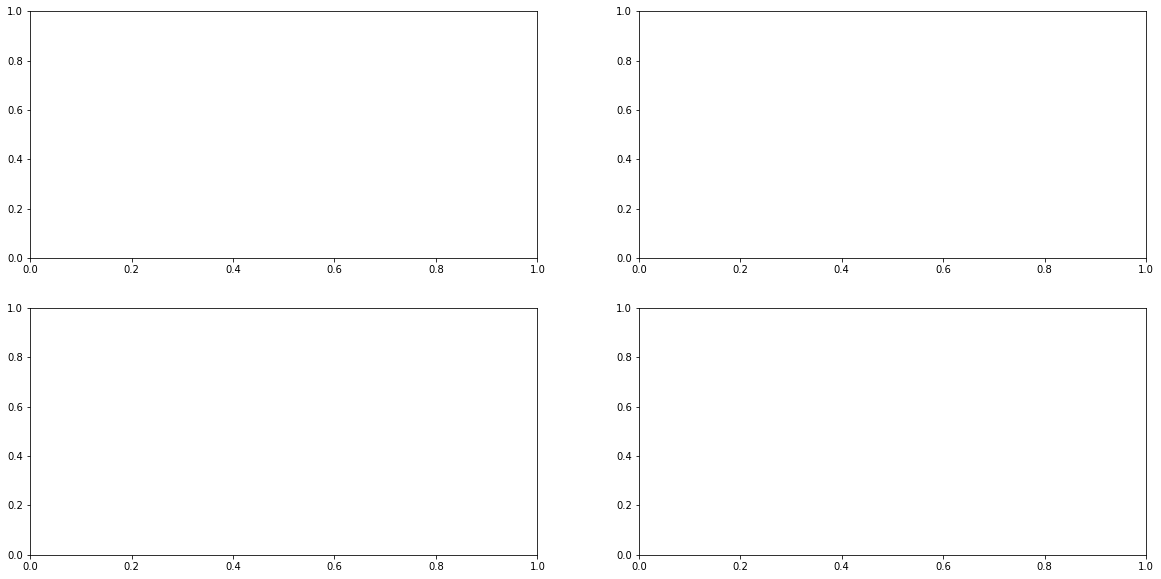

In [15]:
from matplotlib.colors import LogNorm,PowerNorm
fig, ax = plt.subplots(2,2,figsize=(20,2*5))
hist_norm = PowerNorm(0.25)

plt.sca(ax[0][0])
plt.hist2d(RV_Lo[:,0,:,:].flat[:],ST_Lo[:,0,:,:].flat[:],bins=50,density=False,norm=hist_norm)
plt.colorbar()
plt.xlabel("$\zeta/f$")
plt.ylabel("$\sigma/f$")
plt.title("Lo freq, z=0")

plt.sca(ax[0][1])
plt.hist2d(RV_Lo[:,1,:,:].flat[:],ST_Lo[:,1,:,:].flat[:],bins=50,density=False,norm=hist_norm)
plt.colorbar()
plt.xlabel("$\zeta/f$")
plt.ylabel("$\sigma/f$")
plt.title("Lo freq, z=H")

plt.sca(ax[1][0])
plt.hist2d(RV_Hi[:,0,:,:].flat[:],ST_Hi[:,0,:,:].flat[:],bins=50,density=False,norm=hist_norm)
plt.colorbar()
plt.xlabel("$\zeta/f$")
plt.ylabel("$\sigma/f$")
plt.title("Hi freq, z=0")

plt.sca(ax[1][1])
plt.hist2d(RV_Hi[:,1,:,:].flat[:],ST_Hi[:,1,:,:].flat[:],bins=50,density=False,norm=hist_norm)
plt.colorbar()
plt.xlabel("$\zeta/f$")
plt.ylabel("$\sigma/f$")
plt.title("Hi freq, z=H")

## Nueva escala de transición

Entonces, probaremos una definición distinta para una escala de transición que separe la submesoescala. Dicha definición busca una escala para la cual la distrubución de $\zeta$ en $z=0$ para escalas mayores a $L_t$ sea aproximadamente simétrica. En términos de la asimetría estadística (_skewness_) $\overline{\mu_3}$:

$\left|\overline{\mu_3}\right| < 0.5 $

In [27]:
fname_fmt = "/home/antonio/Tesis/Datasets/{0}/days/{1}0_00{2:03d}.txt"
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
scales = [x for x in range(12,277,15)]
len(scales)

18

In [15]:
def UV4id(id,idx_t):
    for idx,t in enumerate(idx_t):
        U_ = np.loadtxt(fname_fmt.format(id,"U",t))
        V_ = np.loadtxt(fname_fmt.format(id,"V",t))
        if idx==0:
            print(id,t)
            #print(U_.shape)
            shape_uv = U_.shape
            print("U shape",shape_uv)
            shape = (len(idx_t),shape_uv[0],shape_uv[1])
            U = np.zeros(shape)
            V = np.zeros(shape)
        U[idx,:,:] = U_
        V[idx,:,:] = V_
        
    return U,V

In [16]:
fname_fmt_ = "/home/antonio/Tesis/Datasets/{}/days/{}.txt"
def dxdyf4id(id):
    dx_ = np.loadtxt(fname_fmt_.format(id,"dx"))
    dy_ = np.loadtxt(fname_fmt_.format(id,"dy"))
    f_ = np.loadtxt(fname_fmt_.format(id,"f"))
    
    return dx_,dy_,f_

In [17]:
def dxdy_avg(dx,dy):
    dx_avg = np.mean(dx.flatten())
    dy_avg = np.mean(dy.flatten())
    return dx_avg,dy_avg

In [18]:
def rv_(u,v,dx,dy):
    return (np.gradient(v,axis=-1,edge_order=2)/dx) - (np.gradient(u,axis=-2,edge_order=2)/dy)

In [19]:
def ro_lohi(U,V,DX,DY,F,scale_km):
    dx,dy = dxdy_avg(DX,DY)
    #print("Avg dx,dy",dx,dy)
    u_lo,u_hi_ = filter_fft_butterworth(U,Lt=scale_km*1000,dx=dx,dy=dy)
    u_hi,_ = filter_fft_butterworth(u_hi_,Lt=5*1000,dx=dx,dy=dy)
    v_lo,v_hi_ = filter_fft_butterworth(V,Lt=scale_km*1000,dx=dx,dy=dy)
    v_hi,_ = filter_fft_butterworth(v_hi_,Lt=5*1000,dx=dx,dy=dy)
    rv_lo = rv_(u_lo,v_lo,DX,DY)
    rv_hi = rv_(u_hi,v_hi,DX,DY)
    return rv_lo/F,rv_hi/F

def ro_rms_lohi(U,V,DX,DY,F):
    #skew_lo = np.zeros((1,len(scales))).flatten()
    #skew_hi = np.zeros((1,len(scales))).flatten()
    rms_ro_lo = np.zeros((1,len(scales))).flatten()
    rms_ro_hi = np.zeros((1,len(scales))).flatten()

    for scale,i in zip(scales,range(len(scales))):
        #print(scale)
        ro_lo,ro_hi = ro_lohi(U,V,DX,DY,F,scale)
        #skew_lo[i] = skew(ro_lo.flatten())
        #skew_hi[i] = skew(ro_hi.flatten())
        rms_ro_lo[i] = np.sqrt(np.mean(np.square(ro_lo.flatten())))
        rms_ro_hi[i] = np.sqrt(np.mean(np.square(ro_hi.flatten())))

    return rms_ro_lo,rms_ro_hi

In [20]:
def lt4uv(U,V,DX,DY,F,id,season):
    print("rms(Ro) for all scales ({},{})".format(id,season))
    rms_ro_lo,rms_ro_hi = ro_rms_lohi(U,V,DX,DY,F)
    #sk_lo = np.abs(skew_lo)
    #idx_lt = np.where(skew_hi>=np.max(skew_hi))[0][-1]
    #idx_where = np.where(sk_lo==np.min(sk_lo))[0]
    #idx_where = np.where(np.abs(sk_lo)<=0.5[0])
    #idx_where = np.where(max_ro_lo<=0.5)[0]
    #idx_where = np.where(max_ro_lo<=np.sqrt(0.1))[0]
    #idx_where = np.where(max_ro_lo<=np.sqrt(0.1) or max_ro_lo<=0.5)[0]
    #idx_where = np.where(max_ro_lo<=np.sqrt(0.1))[0]
    #print(idx_where)
    #if len(idx_where):
    #    idx_lt = idx_where[0]
    #else:
    #    idx_lt = -1 # Tomamos la última
    
    #lt = scales[idx_lt]
    #print("lt",lt)
    #min_sk = min(np.min(skew_lo),np.min(skew_hi),-0.5)-0.1
    #max_sk = max(np.max(skew_lo),np.max(skew_hi),+0.5)+0.1

    print("Plotting")
    #fig,ax = plt.subplots(1,1,figsize=(10,5))
    plt.figure()#figsize=(10,12))
    #ax = ax.flat[:]

    #plt.sca(ax[0]) 
    plt.plot(scales,rms_ro_lo)
    plt.plot(scales,rms_ro_hi)
    #plt.sca(ax[0].twinx())
    #plt.plot(scales,max_ro_lo)                          # Max Ro
    #plt.plot([scales[0],scales[-1]],[0.5,0.5],'r-')# 1/sqrt(10)
    #plt.plot([lt,lt],[min_sk,max_sk],color='grey',linestyle='dashed')              # Lt
    #plt.plot([scales[0],scales[-1]],[0.316,0.316],'r:')# 1/sqrt(10)
    #plt.legend(["Max Ro Low"])
    #plt.sca(ax[0])
    #plt.plot([scales[0],scales[-1]],[0.5,0.5],'k--')    # Upper bound
    #plt.plot([scales[0],scales[-1]],[0,0],'k-')         # Zero skewness
    #plt.plot([scales[0],scales[-1]],[-0.5,-0.5],'k--')  # Lower bound
    plt.legend(["RMS Low Kh","RMS High Kh"])
    #plt.ylim([min_sk,min(np.max(max_ro_lo),max_sk,3)+0.1])

    #plt.sca(ax[1])
    #ro_lo_lt,ro_hi_lt = ro_lohi(U,V,DX,DY,F,lt)
    #ro_lo_lt_flat,ro_hi_lt_flat = ro_lo_lt.flatten(),ro_hi_lt.flatten()
    #plt.hist([ro_lo_lt_flat,ro_hi_lt_flat],density=True,bins=101,log=True)
    #plt.legend(["Lo","Hi"])
    
    plt.suptitle("{}/{}".format(id,season))
    plt.show()
    
    return rms_ro_lo,rms_ro_hi

#### Calculamos para las regiones de cada corriente

In [21]:
ids_Cal = [762, 787, 809, 831, 852, 868] # California -- 23 to 51 N
ids_Can = [709, 730, 750, 771] # Canarias -- 16 to 36 N
ids_Peru = [450, 572, 596, 616, 636] # Peru Chile -- 5 to 45 S
ids_Ben = [459, 533, 556, 578, 602] # Benguela -- 15 to 37 S ** Quitamos la **459** y ponemos la 602

In [29]:
idx_t = {"JFM": idx_t_JFM, "JAS": idx_t_JAS}

In [23]:
## Los resultados se guardan en la siguiente estructura:
#{
#    season: {
#        id: {
#            "scales": scales,
#            "sk_lo": sk_lo,
#            "sk_hi": sk_hi,
#            "max_ro_lo": max_ro_lo,
#            "lt": lt, # L_t: escala para la cual ro_max_lo<=lo_thr
#            "lt_thr": 1/sqrt(10) # Umbral utilizado para definir L_t
#            "ro_lo_lt": ro_lo_lt,
#            "ro_hi_lt": ro_hi_lt
#        }
#    }
#}

def lt_4ids(ids,seasons,res=None):
    res_ = {} if res is None else res
    for r_id in ids:
        #print(r_id)
        DX_id,DY_id,F_id = dxdyf4id(r_id)
        for season in seasons:
            print(r_id,season)
            idx_t_season = idx_t[season]
            #print(DX_id.shape,DY_id.shape,F_id.shape)
            U_id,V_id = UV4id(r_id,idx_t_season)
            #print(U_ASO.shape,V_ASO.shape)
            # * Guardando resultado
            rms_ro_lo,rms_ro_hi = lt4uv(U_id,V_id,DX_id,DY_id,F_id,r_id,season)
            if season not in res_.keys():
                res_[season] = {}
            res_[season][r_id] = {
                "scales": scales,
                #"sk_lo": sk_lo,
                #"sk_hi": sk_hi,
                #"max_ro_lo": max_ro_lo,
                #"lt": lt,
                #"lt_thr": lt_thr,
                "rms_ro_lo": rms_ro_lo,
                "rms_ro_hi": rms_ro_hi
            }
    return res_

##### California

762 JAS
762 292
U shape (288, 289)
rms(Ro) for all scales (762,JAS)
Plotting


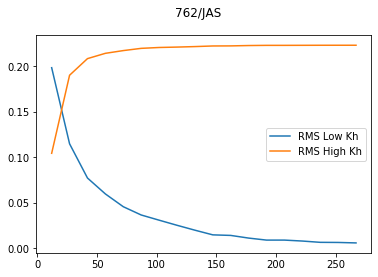

762 JFM
762 110
U shape (288, 289)
rms(Ro) for all scales (762,JFM)
Plotting


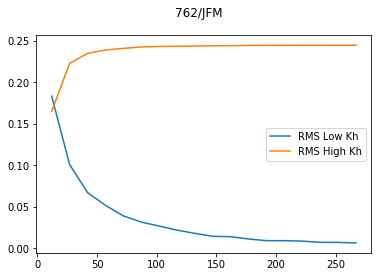

787 JAS
787 292
U shape (291, 289)
rms(Ro) for all scales (787,JAS)
Plotting


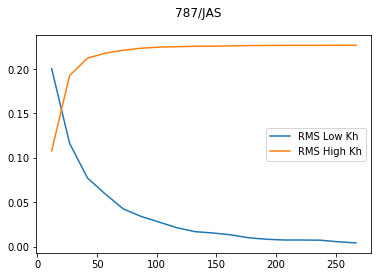

787 JFM
787 110
U shape (291, 289)
rms(Ro) for all scales (787,JFM)
Plotting


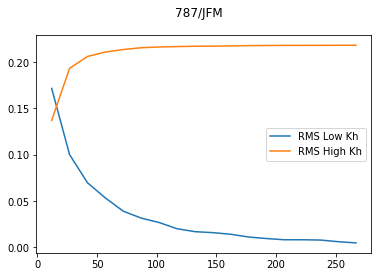

809 JAS
809 292
U shape (288, 287)
rms(Ro) for all scales (809,JAS)
Plotting


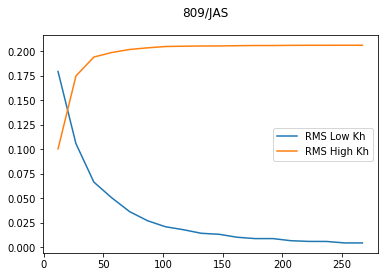

809 JFM
809 110
U shape (288, 287)
rms(Ro) for all scales (809,JFM)
Plotting


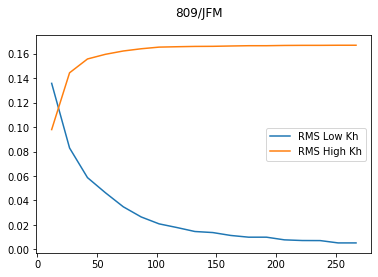

831 JAS
831 292
U shape (290, 287)
rms(Ro) for all scales (831,JAS)
Plotting


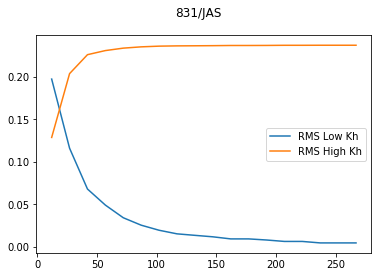

831 JFM
831 110
U shape (290, 287)
rms(Ro) for all scales (831,JFM)
Plotting


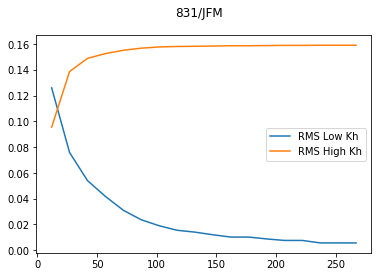

852 JAS
852 292
U shape (288, 287)
rms(Ro) for all scales (852,JAS)
Plotting


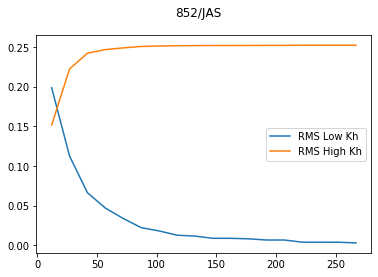

852 JFM
852 110
U shape (288, 287)
rms(Ro) for all scales (852,JFM)
Plotting


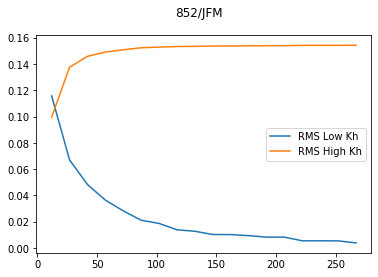

868 JAS
868 292
U shape (290, 289)
rms(Ro) for all scales (868,JAS)
Plotting


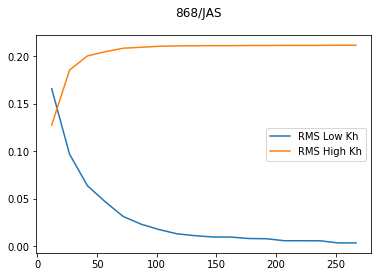

868 JFM
868 110
U shape (290, 289)
rms(Ro) for all scales (868,JFM)
Plotting


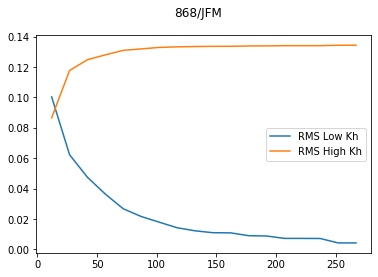

In [30]:
resCal = lt_4ids(ids_Cal,["JAS","JFM"])

##### Canarias

709 JAS
709 292
U shape (288, 289)
rms(Ro) for all scales (709,JAS)
Plotting


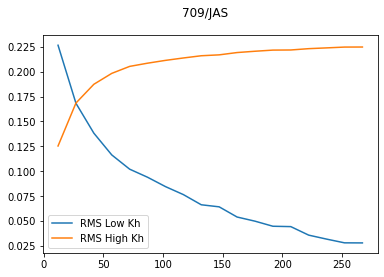

709 JFM
709 110
U shape (288, 289)
rms(Ro) for all scales (709,JFM)
Plotting


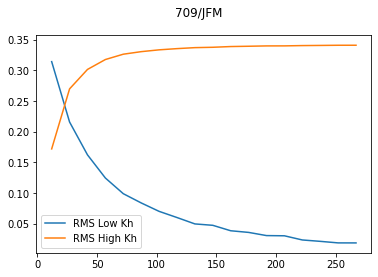

730 JAS
730 292
U shape (290, 289)
rms(Ro) for all scales (730,JAS)
Plotting


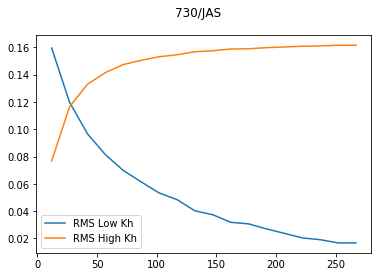

730 JFM
730 110
U shape (290, 289)
rms(Ro) for all scales (730,JFM)
Plotting


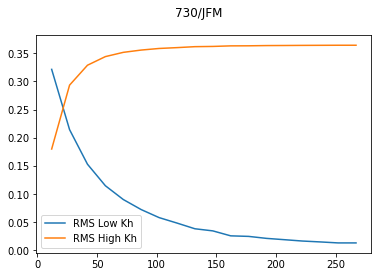

750 JAS
750 292
U shape (288, 289)
rms(Ro) for all scales (750,JAS)
Plotting


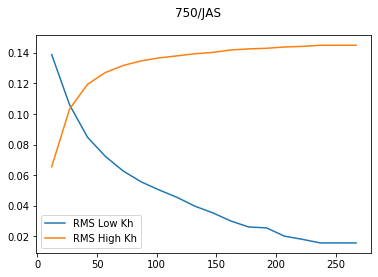

750 JFM
750 110
U shape (288, 289)
rms(Ro) for all scales (750,JFM)
Plotting


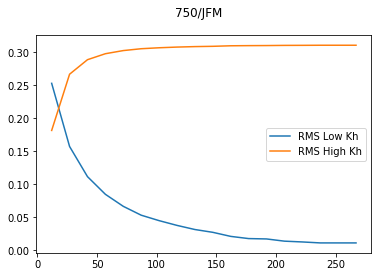

771 JAS
771 292
U shape (291, 289)
rms(Ro) for all scales (771,JAS)
Plotting


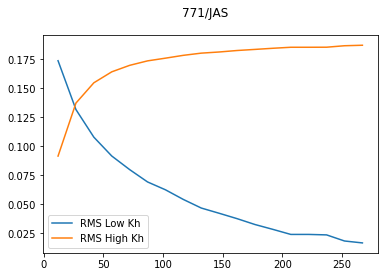

771 JFM
771 110
U shape (291, 289)
rms(Ro) for all scales (771,JFM)
Plotting


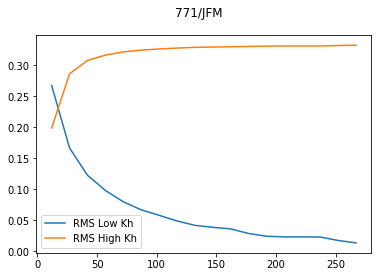

In [31]:
resCan = lt_4ids(ids_Can,["JAS","JFM"])

##### Peru-Chile 

450 JAS
450 292
U shape (290, 289)
rms(Ro) for all scales (450,JAS)
Plotting


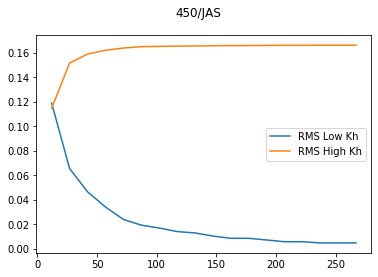

450 JFM
450 110
U shape (290, 289)
rms(Ro) for all scales (450,JFM)
Plotting


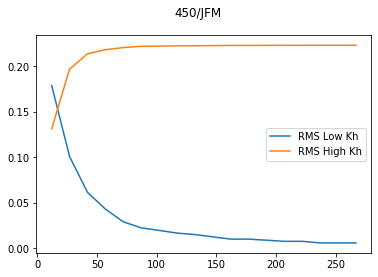

572 JAS
572 292
U shape (290, 289)
rms(Ro) for all scales (572,JAS)
Plotting


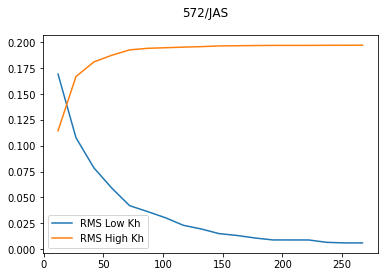

572 JFM
572 110
U shape (290, 289)
rms(Ro) for all scales (572,JFM)
Plotting


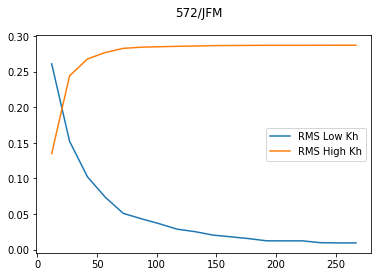

596 JAS
596 292
U shape (288, 289)
rms(Ro) for all scales (596,JAS)
Plotting


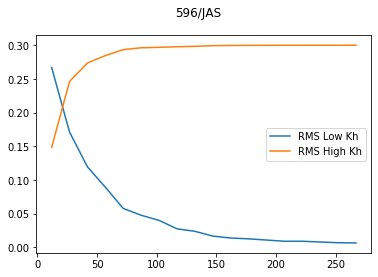

596 JFM
596 110
U shape (288, 289)
rms(Ro) for all scales (596,JFM)
Plotting


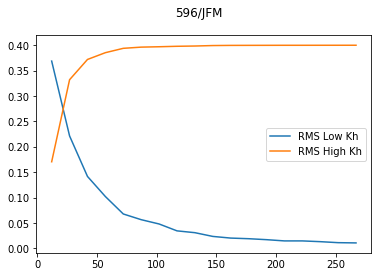

616 JAS
616 292
U shape (290, 289)
rms(Ro) for all scales (616,JAS)
Plotting


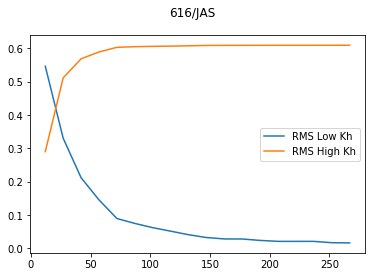

616 JFM
616 110
U shape (290, 289)
rms(Ro) for all scales (616,JFM)
Plotting


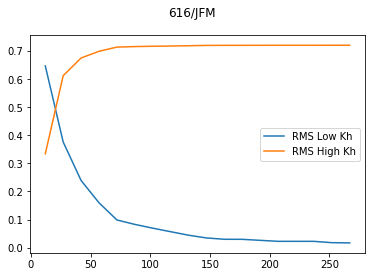

636 JAS
636 292
U shape (288, 289)
rms(Ro) for all scales (636,JAS)
Plotting


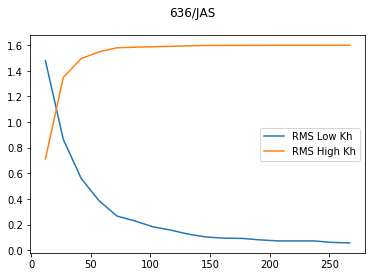

636 JFM
636 110
U shape (288, 289)
rms(Ro) for all scales (636,JFM)
Plotting


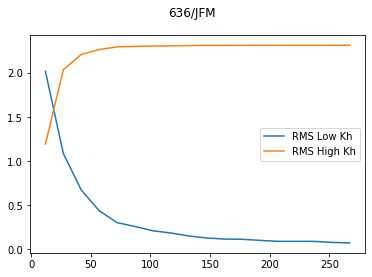

In [32]:
resPeru = lt_4ids(ids_Peru,["JAS","JFM"])

##### Benguela

459 JAS
459 292
U shape (288, 289)
rms(Ro) for all scales (459,JAS)
Plotting


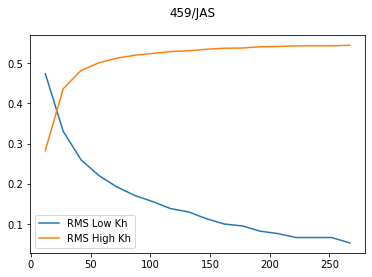

459 JFM
459 110
U shape (288, 289)
rms(Ro) for all scales (459,JFM)
Plotting


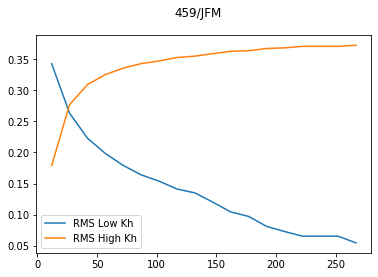

533 JAS
533 292
U shape (288, 289)
rms(Ro) for all scales (533,JAS)
Plotting


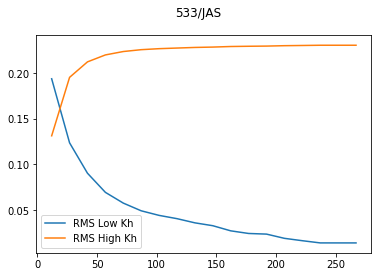

533 JFM
533 110
U shape (288, 289)
rms(Ro) for all scales (533,JFM)
Plotting


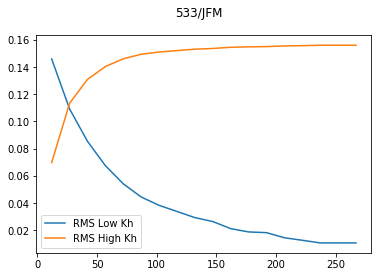

556 JAS
556 292
U shape (290, 289)
rms(Ro) for all scales (556,JAS)
Plotting


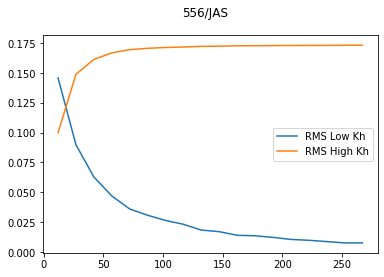

556 JFM
556 110
U shape (290, 289)
rms(Ro) for all scales (556,JFM)
Plotting


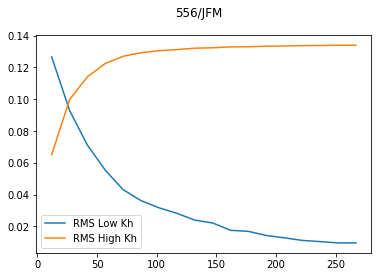

578 JAS
578 292
U shape (288, 289)
rms(Ro) for all scales (578,JAS)
Plotting


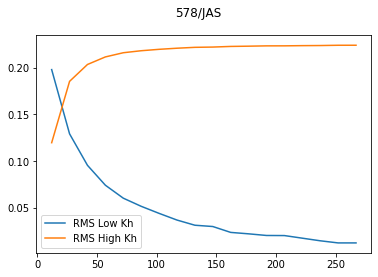

578 JFM
578 110
U shape (288, 289)
rms(Ro) for all scales (578,JFM)
Plotting


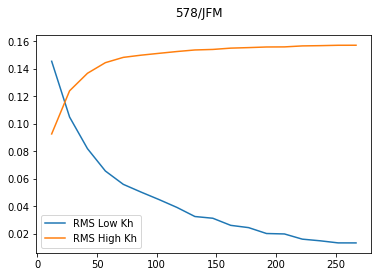

602 JAS
602 292
U shape (290, 289)
rms(Ro) for all scales (602,JAS)
Plotting


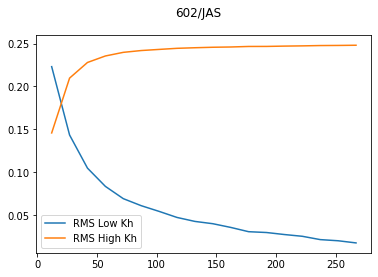

602 JFM
602 110
U shape (290, 289)
rms(Ro) for all scales (602,JFM)
Plotting


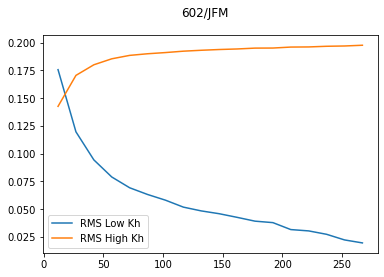

In [47]:
resBen = lt_4ids(ids_Ben,["JAS","JFM"])

##### Kuroshio

733 JAS
733 292
U shape (290, 289)
rms(Ro) for all scales (733,JAS)
Plotting


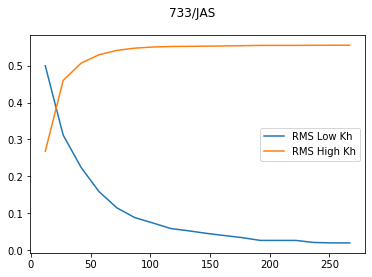

733 JFM
733 110
U shape (290, 289)
rms(Ro) for all scales (733,JFM)
Plotting


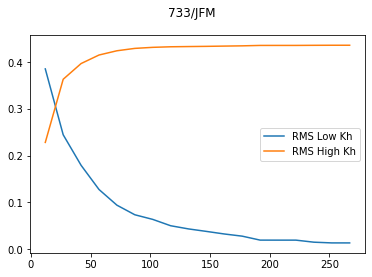

751 JAS
751 292
U shape (288, 289)
rms(Ro) for all scales (751,JAS)
Plotting


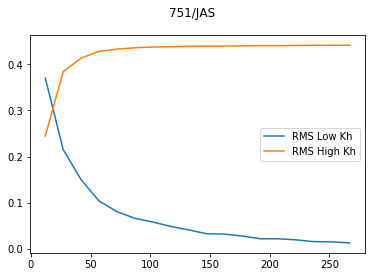

751 JFM
751 110
U shape (288, 289)
rms(Ro) for all scales (751,JFM)
Plotting


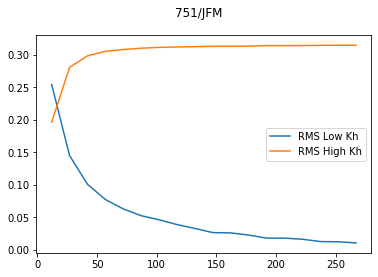

796 JAS
796 292
U shape (288, 289)
rms(Ro) for all scales (796,JAS)
Plotting


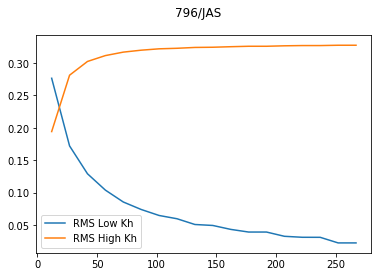

796 JFM
796 110
U shape (288, 289)
rms(Ro) for all scales (796,JFM)
Plotting


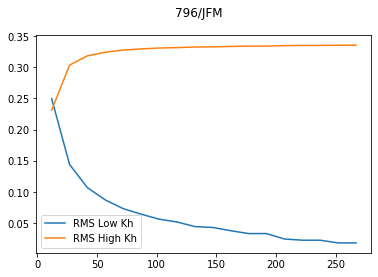

In [48]:
ids_Kuro = [733,751,796]
resKuro = lt_4ids(ids_Kuro,["JAS","JFM"])

##### Función para graficar MaxRo para una corriente

In [49]:
lats4id = {
    762: 26.641, 787: 31.462, 809: 36.056, 831: 40.411, 852: 44.521, 868: 48.383,
    709: 16.398, 730: 21.611, 750: 26.641, 771: 31.462,
    450: -40.411, 572: -21.611, 596: -16.398, 616: -11.032, 636: -5.552,
    459: -36.056, 533: -26.641, 556: -21.611, 578: -16.398, 602: -11.032,
    733: 21.612, 751: 26.642, 796: 36.055
}

In [56]:
def createMaxRoPlot(res,title,hem,ax,var):
    #max_x = 50
    max_y = 0
    ids_ = set([])
    plt.sca(ax)
    for season_id,season_v in res.items():
        #print(season_id)
        linestyle = "-" if ((season_id=="JAS" and hem=="N") or (season_id=="JFM" and hem=="S")) else "--" # summer or winter
        for id_k,id_v in season_v.items():
            ids_.add(id_k)
            #plt.sca(ax[idx])
            leg = "{} @ {} {}".format(id_k,lats4id[id_k],hem)
            #max_x = max(max_x,id_v["lt"])
            max_y = max(max_y,id_v[var].max())
            plt.plot(id_v["scales"],id_v[var],linestyle=linestyle,label=leg)
        ax.set_prop_cycle(None) # Reset color cycle
    #plt.plot([scales[0],scales[-1]],[np.sqrt(0.1),np.sqrt(0.1)],'r:')
    # Legends -- see https://stackoverflow.com/questions/13303928/how-to-make-custom-legend-in-matplotlib
    handles, labels = ax.get_legend_handles_labels()
    display = [x for x in range(len(ids_))] # Solo un display por ID, en lugar del doble
    artistSummer = plt.Line2D((0,1),(0,0), color='gray', linestyle='-')
    artistWinter = plt.Line2D((0,1),(0,0), color='gray', linestyle='--')
    allArtists = [handle for i,handle in enumerate(handles) if i in display]+[artistSummer,artistWinter]
    allLabels = [label for i,label in enumerate(labels) if i in display]+['Summer', 'Winter']
    plt.legend(allArtists,allLabels)
    #plt.legend(ncol=len(res.keys()))
    #
    plt.yscale('log')
    yticks = [10**(-i) for i in range(4)]
    plt.yticks(yticks,["{:.3f}".format(x) for x in yticks])
    plt.ylabel("Ro RMS",size='x-large')
    plt.xlabel("Horizontal scales cutoff",size='x-large')
    #plt.xlim([min(scales),max_x+5])
    plt.xlim([min(scales),max(scales)])
    plt.ylim([0.001,1])
    plt.title(title,size='xx-large')

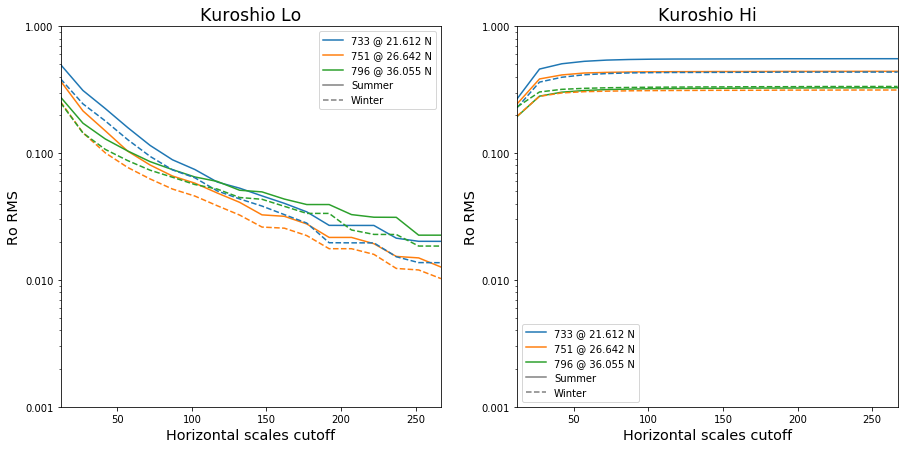

In [57]:
fig_kur, ax_kur = plt.subplots(1,2,figsize=(15,7))
ax_kur = ax_kur.flat[:]
createMaxRoPlot(resKuro,"Kuroshio Lo","N",ax_kur[0],"rms_ro_lo")
createMaxRoPlot(resKuro,"Kuroshio Hi","N",ax_kur[1],"rms_ro_hi")
plt.show()

#### Graficando todas juntas

In [52]:
res_All = [(resCal,"California","N"), (resCan,"Canarias","N"), (resPeru,"Peru","S"), (resBen,"Benguela","S"),(resKuro,"Kuroshio","N")]

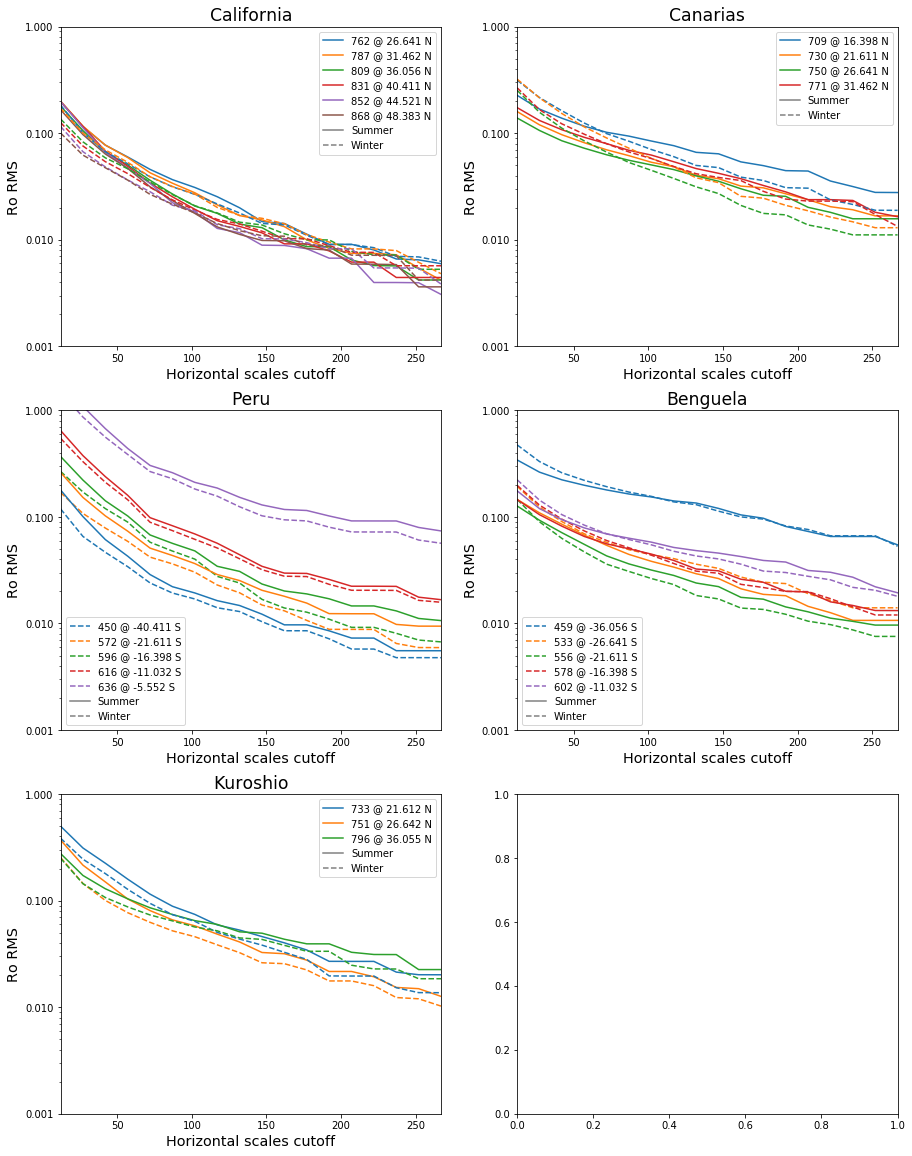

In [58]:
fig, ax = plt.subplots(3,2,figsize=(15,20))
ax = ax.flat[:]

for idx,res_wname in enumerate(res_All):
    #plt.sca(ax[idx])
    res,region,hem = res_wname
    #print(idx,region)
    #print(res.keys())
    createMaxRoPlot(res,region,hem,ax[idx],"rms_ro_lo")
    
plt.show()

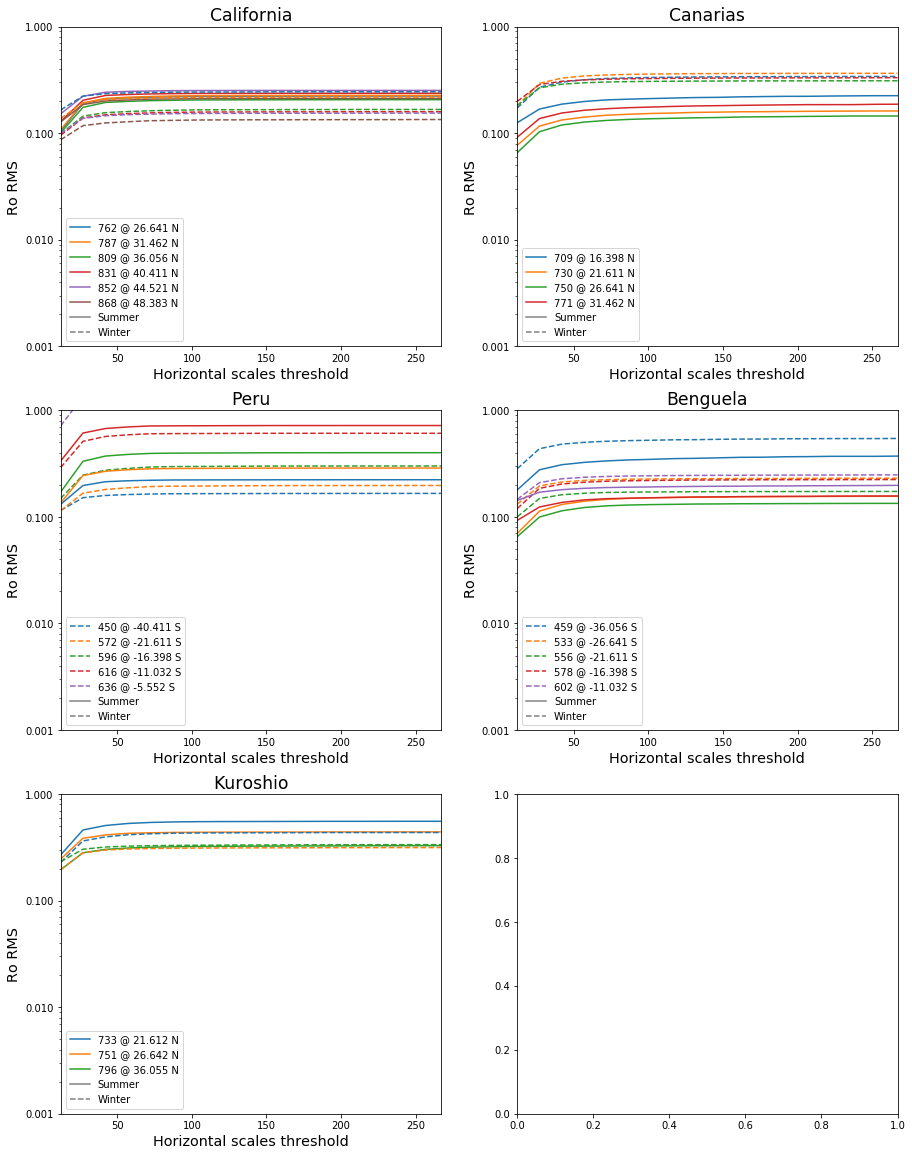

In [54]:
fig, ax = plt.subplots(3,2,figsize=(15,20))
ax = ax.flat[:]

for idx,res_wname in enumerate(res_All):
    #plt.sca(ax[idx])
    res,region,hem = res_wname
    #print(idx,region)
    #print(res.keys())
    createMaxRoPlot(res,region,hem,ax[idx],"rms_ro_hi")
    
plt.show()

In [55]:
%%script false
def diffLt(res_):
    ltJAS = [id_v["lt"] for id_v in res_["JAS"].values()]
    ltJFM = [id_v["lt"] for id_v in res_["JFM"].values()]
    return [x-y for x,y in zip(ltJAS,ltJFM)]

In [ ]:
%%script false
plt.figure(figsize=(10,7))

for idx,res_wname in enumerate(res_All):
    res,region,_ = res_wname
    ltScatter = diffLt(res)
    x_ = [idx]*len(ltScatter)
    plt.scatter(x_,ltScatter)
    #plt.xticks([idx],region)

labels_ = [x for x in zip(*[[idx,r[1]] for idx,r in enumerate(res_All)])]
plt.xticks(*labels_)
plt.ylabel("Lt* diff",size='xx-large')
plt.show()

#### Graficando $L_t$ contra otras variables, para buscar posibles correlaciones

In [15]:
from importlib import reload
import spectral_analysis
reload(spectral_analysis)
from spectral_analysis.tools.spectral_analysis_tools import open_ds_kwe,calc_bm_igw_k
#from spectral_analysis.tools..utils_thesis import coriolis

In [161]:
import pandas as pd
import json

In [231]:
prnt_folder = '/home/antonio/GoogleDrive/Tesis/spectral_analysis'
json_fname_fmt = "{folder}/all_{season}_{var}.json"
spectra_fname_fmt = "{folder}/{season}/{var}/{fname}"

In [234]:
merged_Rd_c1_H_Nbv = pd.read_csv('{}/merged_Rd_c1_H_Nbv.csv'.format(prnt_folder),index_col='s_id')
merged_Rd_c1_H_Nbv.head()

,c1,Rd1,s_id.1,H,f_cph,Nbv_rad_s,Nbv_cph,Nbv_cph_2
s_id,,,,,,,,
2,0.786125,5.770625,2,4596.345550,-0.077758,0.000537,0.307859,0.306695
3,0.780667,5.736083,3,4710.020942,-0.077758,0.000521,0.298343,0.297502
4,0.832167,6.113833,4,4762.354497,-0.077758,0.000549,0.314529,0.313609
5,0.792583,5.822833,5,4187.179894,-0.077758,0.000595,0.340719,0.339711
6,0.627250,4.609167,6,3263.078534,-0.077758,0.000604,0.346008,0.345058


In [240]:
def getSpectrumFnameLat(season,var,id):
    with open(json_fname_fmt.format(folder=prnt_folder,season=season,var=var),'r') as f:
        data = json.load(f)
    s_id = str(id)
    lat = data[s_id]['lat']
    fname = spectra_fname_fmt.format(folder=prnt_folder,season=season,var=var,fname=data[s_id]['fname'])
    return fname,lat

In [378]:
def getSpectrum_bmigw_lohi(season,var,id,Lt_km,log=False):
    # Get data
    fname,lat = getSpectrumFnameLat(season,var,id)
    kh,freq,S = open_ds_kwe(fname,log)
    dk = kh[1]-kh[0]
    id_data = merged_Rd_c1_H_Nbv.loc[id]
    N = id_data["Nbv_cph_2"]
    H = id_data["H"]/1000
    # Calculamos la energía por encima y por debajo de la curva IGW10_M2
    bm_k,igw_k = calc_bm_igw_k(kh,freq,S,lat,Nbv=N,H=H,log=log)
    # Convertimos a energía
    if var=="RV" or var=="DIV":
        bm_k = (bm_k/kh)**2
        igw_k = (igw_k/kh)**2
    # Separamos las partes por encima y por debajo de lt
    kMask_lo = 1./kh>Lt_km
    kMask_hi = 1./kh<=Lt_km
    # Integramos para toda k
    bm_lo_tot = bm_k[kMask_lo].sum()*dk
    bm_hi_tot = bm_k[kMask_hi].sum()*dk
    igw_lo_tot = igw_k[kMask_lo].sum()*dk
    igw_hi_tot = igw_k[kMask_hi].sum()*dk
    return bm_lo_tot,bm_hi_tot,igw_lo_tot,igw_hi_tot

# References

(<a id="cit-Shcherbina2013" href="#call-Shcherbina2013">?</a>) !! _This reference was not found in biblio.bib _ !!



In [ ]:
%%javascript
IPython.notebook.save_notebook()